# Final assignment Introduction to machine learning

In dit notebook wordt er onderzoek gedaan naar de beste manier om afbeeldingen te classificeren in verschillende getallen. Er worden in dit notebook 4 verschillende datasets opgebouwd die elk een andere soort data bevatten. Er wordt gekeken naar pixel informatie, Vision informatie, Gaussian pyramid informatie en de informatie die te halen valt uit een laplacian pyramide. 

Wanneer de verschillende datasets zijn opgebouwd uit de afbeeldingen wordt er onderzoek gedaan naar de verschillende classifiers en naar de verschillende hyperparameters die in deze classfiers verwerkt kunnen worden. De volgende classifiers worden onderzocht:

Random Forest Regressor  
Multi layer perceptron  
Support Vector Machine  
Decision Tree Classifier  
Naive Bayes Classifier  
K-neighbors Classifier  
Ridge Classifier  

De MLP en de Ridge classifier worden ook theoretisch uitgelegd.

Hier op volgend worden analyses uitgevoerd op de verschillende datasets en verschillende classifiers. Aan de hand van deze analyses wordt de beste classifier en de beste dataset uitgekozen om gebruikt te worden in de final notebook.

Dit notebook is gemaakt door: 

Fabian Mijsters  
432601  
432601@student.saxion.nl  

### Inhoud

1. Feature Selection
2. Feature Analyses
3. Preparing the training data
4. Finding the best parameters for the different datasets and models 
5. Training the different models on the datasets
6. Final votingclassifier model
7. Comparison between the datasets using confusion matrix and classification reports
8. Hyperparameter comparison laplacian model
9. Exporting final model with the highest score

In [1]:
import numpy as np
import skimage
from skimage import io,morphology
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.transform import pyramid_gaussian
from skimage.transform.pyramids import pyramid_laplacian
from skimage.transform import pyramid_expand
from sklearn.metrics import confusion_matrix
from skimage.transform import hough_line, hough_line_peaks
from sklearn.pipeline import Pipeline

dataset_path = '../dataset-images'
import seaborn as sns


C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def image_to_binary(image,threshold_corretion=0):
    image = skimage.color.rgb2gray(image)
    thresh = skimage.filters.threshold_otsu(image)
    binary = image > (thresh +threshold_corretion)
    binary = np.invert(binary)
    binary = morphology.dilation(binary,morphology.disk(1))
    return binary

In [3]:
def split_digits_into_image_array(image):
    images = list()
    for i in range(4):
        images.append(image[0:31,(32 * i):(32*i + 31)])
    return images

In [4]:
def show_image(image,number):
    plt.imshow(image)
    plt.text(1,4,number,fontsize=30)

In [5]:
def add_row_to_pixel_dataframe_at_index(region,dataframe,index,square_list,number):
    pixel_based_row = np.array(square_list)
    pixel_based_row = np.append(pixel_based_row,int(number))
    dataframe.loc[index] = pixel_based_row

In [6]:
def add_row_to_vision_dataframe_at_index(region,filled_minus_original,top_bottom_heavy,dataframe,index,contours,horizontal_lines,vertical_lines,diagonal_ltr_lines
                                            ,diagonal_rtl_lines,number):
    vision_based_row = np.array([region.area,region.major_axis_length,region.minor_axis_length,filled_minus_original,region.centroid[0],region.centroid[1],top_bottom_heavy,contours,horizontal_lines,vertical_lines,diagonal_ltr_lines
                                            ,diagonal_rtl_lines,int(number)]).astype(float)
    dataframe.loc[index] = vision_based_row

In [7]:
#add rows below and ontop of image to account for the image ending at the top
def get_contours_in_image(binary_image):
    binary_image = np.insert(binary_image,0,np.full(31, False), axis=0)
    binary_image = np.insert(binary_image,32,np.full(31, False), axis=0)
    contours = skimage.measure.find_contours(binary_image, 0.8)
    return contours

In [8]:
def gaussian_pyramid_from_image(image):
    pyramid = tuple(pyramid_gaussian(image,multichannel=False))
    return(pyramid)


In [9]:
def laplacian_pyramid_from_image(image):
    pyramid = tuple(pyramid_laplacian(image,multichannel=False))
    return pyramid

In [10]:
def image_from_gaussian_pyramid(image):
    pyramid = pyramid_expand(image)
    return(pyramid)

In [11]:
def create_square_list(image):
    square_list=list()
    image = np.around(image)
    margin = int(math.sqrt(image.shape[0]))
    for y in range(0,image.shape[0],margin):
        for x in range(0,image.shape[0],margin):
            square_list.append(np.around(np.sum(image[y:y+margin,x:x+margin])))
    return square_list

In [12]:
# Haal alle lijnen uit de image met behulp van numpy door de rows of kollomen te tellen. haal ook de diagonale lijnen eruit met 
# behulp van de diagonal functie
def get_all_the_lines(image):
    image= np.around(image)
    mask = image>0
    image = image[np.ix_(mask.any(1),mask.any(0))]
    horizontal_line = 0
    vertical_line = 0
    diagonal_line_ltr = 0
    diagonal_line_rtl = 0
    for row in image:
        row = np.trim_zeros(row)
        if len(row) == np.count_nonzero(row):
            horizontal_line += 1
    for col in range(image.shape[1]):
        column = image[:,col]
        column = np.trim_zeros(column)
        if len(column) == np.count_nonzero(column):
            vertical_line += 1
    
    width,_ = image.shape
    inverted_image= np.fliplr(image)
    for i in range(-15,15):
        diagonal_ltr = np.trim_zeros(image.diagonal(i))
        diagonal_rtl = np.trim_zeros(inverted_image.diagonal(i))
        if len(diagonal_ltr) == np.count_nonzero(diagonal_ltr):
            diagonal_line_ltr += 1
        if len(diagonal_rtl) == np.count_nonzero(diagonal_rtl):
            diagonal_line_rtl += 1
    return horizontal_line,vertical_line,diagonal_line_ltr,diagonal_line_rtl

In [13]:
def transform_pyramid_into_1d_array(pyramid,from_layer):
    image_array = list()
    for pyr in pyramid[from_layer:]:
        for row in pyr:
            image_array.extend(row)
    return image_array

In [14]:
def prepare_laplacian_pyramid(pyramid):
    new_pyramid = list()
    for pyr in pyramid:
        pyr[pyr > 0.001] = 1
        pyr = np.around(pyr)
        new_pyramid.append(pyr)
    return new_pyramid

In [15]:
def get_top_bottom(image):
    top_heavy = np.sum(image[:16])
    bottom_heavy = np.sum(image[16:])
    if top_heavy> bottom_heavy:
        return 1
    else:
        return 0
#     return top_heavy,bottom_heavy

In [16]:
# Helper function source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names,ax, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
#     fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",ax=ax)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return fig

# Filling the dataset (Feature Extraction)

Door gebruik te maken van verschillende image recognition technieken worden er 4 datasets gevult. Deze datasets worden daarna gebruikt om classifiers op te trainen en scoren. 

In [17]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
counter = 0
index = 0

# Columns klaar maken voor het pandas dataframe
columns_pixel_based = ["square_1","square_2","square_3","square_4","square_5","square_6","square_7","square_8","square_9",
                       "square_10","square_11","square_12","square_13","square_14","square_15","square_16",'number']
columns_vision_based = ['area','major_axis_length','minor_axis_length','filled_minus_original','center_x','center_y','top_bottom_heavy','contours','horizontal_lines','vertical_lines','diagonal_ltr','diagonal_rtl','number']

columns_gausian_pyramid_based = np.asarray(list(range(341))).astype(str)
columns_gausian_pyramid_based = np.append(columns_gausian_pyramid_based,"number")

columns_laplacian_pyramid_based = np.asarray(list(range(341))).astype(str)
columns_laplacian_pyramid_based = np.append(columns_laplacian_pyramid_based,"number")

# dataframe instantieren. 
dataset_pixel_based = pd.DataFrame(columns = columns_pixel_based)
dataset_vision_based = pd.DataFrame(columns = columns_vision_based)
dataset_gausian_pyramid_based = pd.DataFrame(columns = columns_gausian_pyramid_based)
dataset_laplacian_pyramid_based = pd.DataFrame(columns = columns_laplacian_pyramid_based)


for filename in os.listdir(dataset_path):
    if '.png' not in filename:
        continue
    postal_code_image = io.imread(os.path.join(dataset_path, filename))
    images = split_digits_into_image_array(postal_code_image)
    for i, image in enumerate(images):
        #haal het nummer uit de naam van de afbeelding
        number = filename[i]
        binary = image_to_binary(image)
        
        contours = get_contours_in_image(binary)
        
        postal_code_label = skimage.measure.label(binary)
        
        laplacian_pyramid = laplacian_pyramid_from_image(binary)
        gaussian_pyramid = gaussian_pyramid_from_image(binary)
        # de 2 arrays zijn 2d arrays met de rows en columns uit een afbeelding dit wordt omgezet naar een 1d array door de rows achter elkaar te zetten
        laplacian_array = transform_pyramid_into_1d_array(prepare_laplacian_pyramid(laplacian_pyramid),1)
        gaussian_array = transform_pyramid_into_1d_array(gaussian_pyramid,1)

        laplacian_array.append(int(number))
        gaussian_array.append(int(number))
        
        dataset_gausian_pyramid_based.loc[index] = np.around(np.asarray(laplacian_array))
        dataset_laplacian_pyramid_based.loc[index] = np.around(np.asarray(gaussian_array))
        
        region = skimage.measure.regionprops(postal_code_label, coordinates='rc')[0]
        # Verdeel de afbeelding in aparte vierkanten
        square_list = create_square_list(laplacian_pyramid[1])
        
        horizontal_lines,vertical_lines,diagonal_ltr_lines,diagonal_rtl_lines = get_all_the_lines(binary)
        # Kijk of de afbeelding meer pixels bevat aan de boven of onderkant
        top_bottom_heavy = get_top_bottom(binary)
        
        filled_minus_original = region.filled_area - region.area 
        
        add_row_to_pixel_dataframe_at_index(region,dataset_pixel_based,index,square_list,number)
        
        add_row_to_vision_dataframe_at_index(region,filled_minus_original,top_bottom_heavy,dataset_vision_based,index,len(contours),horizontal_lines,
                                             vertical_lines,diagonal_ltr_lines,
                                             diagonal_rtl_lines,number)
       
        index = index + 1
    counter = counter + 1
    
print("Done creating the data")


C:\Users\fmijs\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.


Done creating the data


# Feature Analysis

Door goed te kijken naar de verschillende features wordt het duidelijk waar de verschillende features goed in zijn. Dus wordt het duidelijk welke getallen de verschillende features goed kunnen herkennen. Deze analyse wordt uitgevoerd met behulp van ViolinPlots die gemaakt zijn met behulp van SeaBorn. 

## Datasets

### Overview

| Datasets          | Features | Pixel Dataset | Vision Dataset        | Gaussian Pyramid Dataset | Laplacian Pyramid Dataset |
|-------------------|----------|---------------|-----------------------|--------------------------|---------------------------|
| Pixel             | 16       | Square 1      | area                  | Pixel values * 341       | Pixel values * 341        |
| Vision            | 12       | Square 2      | major_axis_length     |                          |                           |
| Gaussian Pyramid  | 341      | Square 3      | minor_axis_length     |                          |                           |
| Laplacian Pyramid | 341      | Square 4      | filled_minus_original |                          |                           |
|                   |          | Square 5      | center_x              |                          |                           |
|                   |          | Square 6      | center_y              |                          |                           |
|                   |          | Square 7      | top_bottom_heavy      |                          |                           |
|                   |          | Square 8      | contours              |                          |                           |
|                   |          | Square 9      | horizontal_lines      |                          |                           |
|                   |          | Square 10     | vertical_lines        |                          |                           |
|                   |          | Square 11     | diagonal_ltr          |                          |                           |
|                   |          | Square 12     | diagonal_rtl          |                          |                           |
|                   |          | Square 13     |                       |                          |                           |
|                   |          | Square 14     |                       |                          |                           |
|                   |          | Square 15     |                       |                          |                           |
|                   |          | Square 16     |                       |                          |                           |

### Dataset Pixel

De pixel dataset wordt gevuld met pixel informatie. De dataset bestaat uit 16 features die allemaal een vierkant uit de foto representeren. In elk vierkant worden alle pixels bij elkaar opgeteld en in een array geplaatst die als een vector in de dataset wordt geplaatst met het bij behorende nummer erachter. Voor dat de pixels opgeteld worden wordt eerst de noise uit de afbeelding gehaald en worden de pixels afgerond.

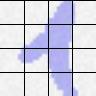

C:\Users\fmijs\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


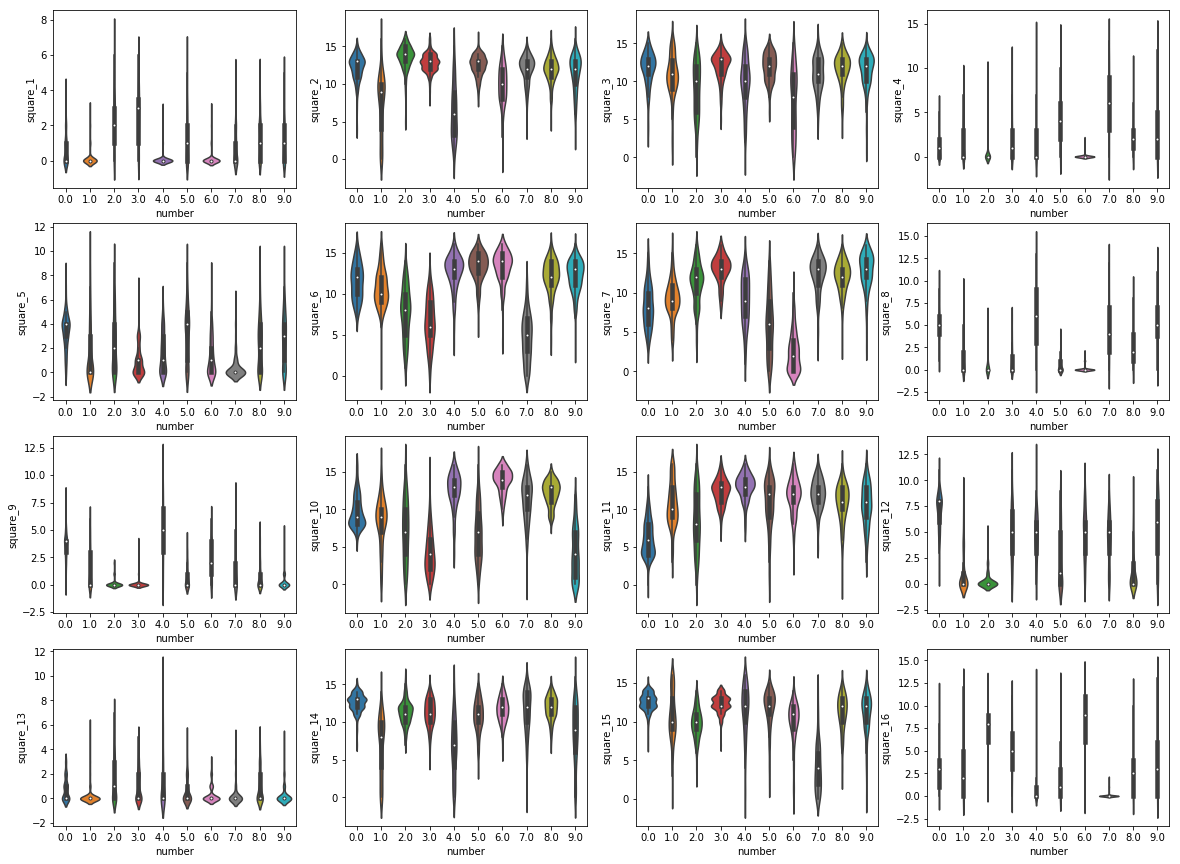

In [18]:
fig2, ax2 = plt.subplots(nrows=4, ncols=4)
fig2.set_figheight(15)
fig2.set_figwidth(20)
for index,column in enumerate(dataset_pixel_based.columns.tolist()):
    if column == 'number':
        break
    holder_dataframe = dataset_pixel_based.melt(id_vars=['number'],value_vars=[column])
    holder_dataframe = holder_dataframe.drop(['variable'],axis=1)
    holder_dataframe.columns = ['number',column]
    sns.violinplot(x='number', y=column, data=holder_dataframe, ax=ax2[int(index/4)][index % 4])


In [19]:
dataset_pixel_based.describe()

,square_1,square_2,square_3,square_4,square_5,square_6,square_7,square_8,square_9,square_10,square_11,square_12,square_13,square_14,square_15,square_16,number
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,1.026042,11.057813,10.692187,2.176563,1.993229,10.426042,9.690104,2.643229,1.463542,8.988021,10.744271,3.592708,0.720833,10.306250,10.472917,3.566667,4.532813
std,1.389812,3.248648,3.049965,2.974194,2.066749,3.758714,4.125987,3.040684,2.046037,4.373562,3.220362,3.038360,1.293824,3.296051,3.412465,3.565472,2.868122
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.000000,9.000000,0.000000,0.000000,8.000000,7.000000,0.000000,0.000000,6.000000,9.000000,0.000000,0.000000,9.000000,9.000000,0.000000,2.000000
50%,0.000000,12.000000,11.000000,1.000000,1.000000,11.000000,11.000000,1.000000,0.000000,10.000000,11.000000,4.000000,0.000000,11.000000,11.000000,3.000000,5.000000
75%,2.000000,13.000000,13.000000,3.000000,4.000000,13.000000,13.000000,5.000000,3.000000,13.000000,13.000000,6.000000,1.000000,13.000000,13.000000,6.000000,7.000000
max,7.000000,16.000000,16.000000,13.000000,10.000000,16.000000,16.000000,13.000000,11.000000,16.000000,16.000000,12.000000,10.000000,16.000000,16.000000,13.000000,9.000000


### Dataset Vision

De vision dataset wordt gevuld met informatie die met behulp van skimage of sklearn uit de afbeelding gehaald kan worden. Daarnaast wordt ook gebruik gemaakt van het aantal lijnen dat door de afbeelding lopen. 

#### Area
Area representeerd de oppervlakte van het cijfer in de afbeelding

#### Major axis length
De major axis length is de lengte van de langste as

Uit de analyse van de onderstaande violinplot blijkt dat de major axis length feature het nummer 2 & 4 als uniek getal heeft en dus helpt met de classificatie van nummer 2 & 4

#### Minor axis length
De minor axis length is de lengte van de kortste as

Uit de analyse van de onderstaande violinplot blijkt dat de minor axis length feature het nummer 0 als uniek getal heeft en dus helpt met de classificatie van nummer 0

#### Filled minus original
De filled minus original feature is de oppervlakte van de lege delen van een cijfer in een afbeelding

#### center_x
De center x is de locatie van het midden van de image aan de hand van waar de afbeelding ingekleurd is door het cijfer. Het zwaartepunt van een afbeelding

Uit de analyse van de onderstaande violinplot blijkt dat de center x feature het nummer 6 & 7 als uniek getal heeft en dus helpt met de classificatie van nummer 6 & 7

#### center_y
De center y is de locatie van het midden van de image aan de hand van waar de afbeelding ingekleurd is door het cijfer. Het zwaartepunt van een afbeelding

#### Top bottom heavy
Top bottom heavy geeft aan met behulp van een 1 dat het bovenste gedeelte van een afbeelding meer pixels bevat dan het onderste gedeelte. Deze feature heeft de waarde 0 als het omgekeerde waar is. 

Uit de analyse van de onderstaande violinplot blijkt dat de Top bottom heavy feature het nummer 9 als uniek getal heeft en dus helpt met de classificatie van nummer 9

#### Contours
Het Contour feature geeft het aantal omtrekken in een afbeelding weer bij een 8 zijn dit er 3 aangezien er 2 binnenste contouren zijn en 1 voor de buitenste omtrek

Uit de analyse van de onderstaande violinplot blijkt dat de Contours feature het nummer 8 goed kan herkennen aangezien dit het enige nummer met hoge uitschieters is in de grafiek

#### Horizontal lines
Het horizontal lines feature geeft het aantal niet onderbroken horizontale lijnen aan in een afbeelding.

#### Vertical lines
Het vertical lines feature geeft het aantal niet onderbroken verticale lijnen aan in een afbeelding.

Uit de analyse van de onderstaande violinplot blijkt dat de vertical lines feature het nummer 3 & 5 goed detecteert

#### Diagonal Left to Right
Het diagonal left to right feature geeft het aantal niet onderbroken diagonale lijnen van links naar rechts aan in een afbeelding.

Uit de analyse van de onderstaande violinplot blijkt dat de Diagonal left to right feature het nummer 1 als uniek getal heeft en dus helpt met de classificatie van nummer 1

#### Diagonal Right to Left
Het diagonal right to left feature geeft het aantal niet onderbroken diagonale lijnen van rechts naar links aan in een afbeelding.

C:\Users\fmijs\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


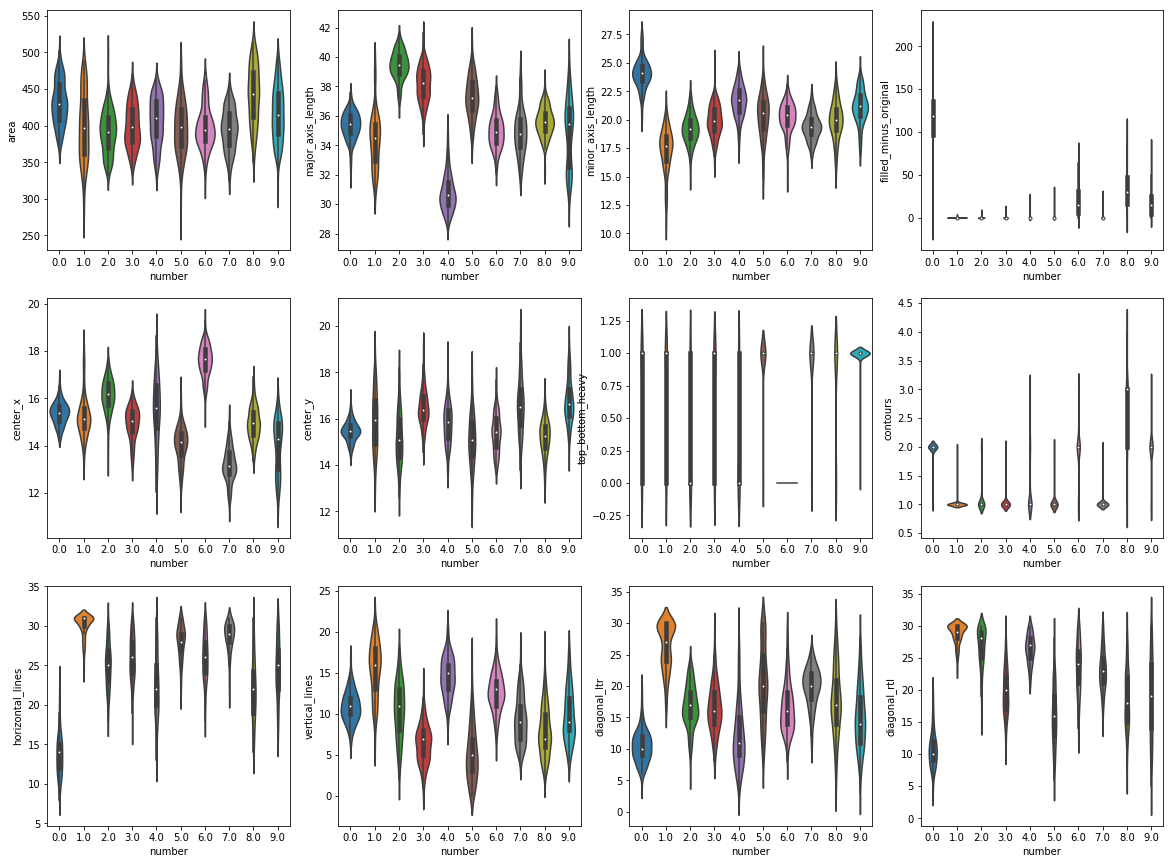

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=4)
fig.set_figheight(15)
fig.set_figwidth(20)
for index,column in enumerate(dataset_vision_based.columns.tolist()):
    if column == 'number':
        break
    holder_dataframe = dataset_vision_based.melt(id_vars=['number'],value_vars=[column])
    holder_dataframe = holder_dataframe.drop(['variable'],axis=1)
    holder_dataframe.columns = ['number',column]
    sns.violinplot(x='number', y=column, data=holder_dataframe, ax=ax[int(index/4)][index % 4])


In [21]:
dataset_vision_based.describe()

,area,major_axis_length,minor_axis_length,filled_minus_original,center_x,center_y,top_bottom_heavy,contours,horizontal_lines,vertical_lines,diagonal_ltr,diagonal_rtl,number
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,407.250000,35.595514,20.274450,17.858333,15.098430,15.800149,0.632812,1.455208,24.777083,10.298958,17.280208,21.399479,4.532813
std,37.530547,2.653717,2.223549,36.134552,1.447589,1.129553,0.482164,0.626889,5.154041,4.284100,6.019131,6.439383,2.868122
min,270.000000,28.505900,10.832460,0.000000,11.300613,12.065282,0.000000,1.000000,8.000000,0.000000,3.000000,4.000000,0.000000
25%,380.000000,34.132400,18.909758,0.000000,14.201536,15.067046,0.000000,1.000000,22.000000,7.000000,13.000000,17.000000,2.000000
50%,405.000000,35.629523,20.197647,0.000000,15.062679,15.742814,1.000000,1.000000,26.000000,10.000000,17.000000,22.000000,5.000000
75%,433.000000,37.423280,21.632427,19.000000,15.923336,16.480951,1.000000,2.000000,29.000000,13.000000,21.000000,27.000000,7.000000
max,515.000000,41.615201,27.709111,204.000000,19.320113,19.923077,1.000000,4.000000,31.000000,22.000000,30.000000,30.000000,9.000000


### Dataset Gaussian Pyramid

Een gaussian pyramide is een veel gebruikte techniek in computer vision. Alle even rijen en kolommen worden weggehaald en dan wordt er een gaussian blur toegepast. Dit blijft doorgaan tot er geen even rijen en kolommen meer zijn. Hier onder een voorbeeld van https://scikit-image.org/docs/dev/auto_examples/transform/plot_pyramid.html.

De pixels van de onderste 5 lagen worden toegevoegd aan een array 1d array en als vectors in de dataset geplaatst met het nummer achteraan bijgevoegd

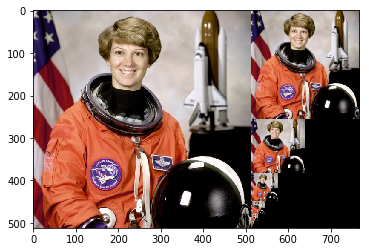

In [22]:
image= data.astronaut()
rows, cols, dim = image.shape
pyramid = tuple(pyramid_gaussian(image, downscale=2, multichannel=True))

composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)
composite_image[:rows, :cols , :] = pyramid[0]
i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

### Dataset Laplacian Pyramid

Een laplacian pyramide is een veel gebruikte techniek in computer vision. Er wordt eerst een gaussian pyramide opgesteld en deze pyramide wordt over de originele image heen gelegd hierdoor vallen de belangrijke features van de afbeelding meer op en worden hier accenten op gelegd. Hier onder een voorbeeld van https://scikit-image.org/docs/dev/auto_examples/transform/plot_pyramid.html.

De pixels van de onderste 5 lagen worden toegevoegd aan een array 1d array en als vectors in de dataset geplaatst met het nummer achteraan bijgevoegd

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


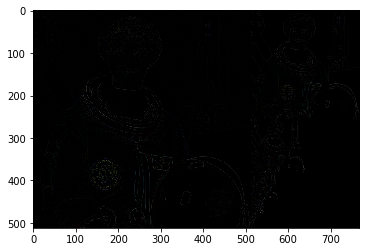

In [23]:
image= data.astronaut()
rows, cols, dim = image.shape
pyramid = tuple(pyramid_laplacian(image, downscale=2, multichannel=True))

composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)
composite_image[:rows, :cols , :] = pyramid[0]
i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

# Preparing the training data

Door de data te shufflen wordt er voor gezorgt dat het splitten van de data in een training en testing set resulteert in 2 sets die netjes verdeeld zijn met betrekking tot de verschillende getallen en dit zorgt er op zijn beurt weer voor dat de classifiers op alle getallen evenveel trainen

In [24]:
dataset_gausian_pyramid_based = dataset_gausian_pyramid_based.sample(frac=1,random_state=0).reset_index(drop=True)
dataset_laplacian_pyramid_based = dataset_laplacian_pyramid_based.sample(frac=1,random_state=0).reset_index(drop=True)
dataset_pixel_based = dataset_pixel_based.sample(frac=1,random_state=0).reset_index(drop=True)
dataset_vision_based = dataset_vision_based.sample(frac=1,random_state=0).reset_index(drop=True)

##### Run below for alligning

In [25]:
%%html
<style>
table {float:left}
</style>

### Evenly distribute training data to combat Classification Bias

Dit wordt uiteindelijk niet gebruikt aangezien de dataset al uit zichzelf al goed verdeeld is. Eventueel had de 0 nog bijgevuld kunnen worden door de bestaande afbeeldingen van het getal 0 te spiegelen of om te draaien. 

| Number | Count |
|--------|-------|
| 0      | 177   |
| 1      | 198   |
| 2      | 195   |
| 3      | 199   |
| 4      | 186   |
| 5      | 187   |
| 6      | 195   |
| 7      | 199   |
| 8      | 180   |
| 9      | 204   |

In [26]:
# Lowest number of labels is number 0 with 177 vectors
# remove_amount = list()
# indices_per_number = list()
# for i in range(10):
#     remove_amount.append(len(dataset_vision_based[dataset_vision_based['number'] == i].index) - 177)
#     indices = dataset_vision_based[ dataset_vision_based['number'] == i].index.tolist()
#     random_selected_indices = random.sample(indices,remove_amount[i])
#     indices_per_number.append(random_selected_indices)

# for indices in indices_per_number:
#     dataset_vision_based = dataset_vision_based.drop(indices)
#     dataset_gausian_pyramid_based = dataset_gausian_pyramid_based.drop(indices)
#     dataset_laplacian_pyramid_based = dataset_laplacian_pyramid_based.drop(indices)
#     dataset_pixel_based = dataset_pixel_based.drop(indices)

## Use kfold SelectKBest to select best features and ensure cross validation

Om te zorgen dat de classifiers alle data te zien krijgen wordt gebruik gemaakt van cross validation door kfold. Ook wordt SelectKBest gebruikt om de beste features uit de dataset te selecteren de resultaten van SelectKBest worden niet gebruikt omdat er met Manual Selection gewerkt wordt. 

Done preparing the data


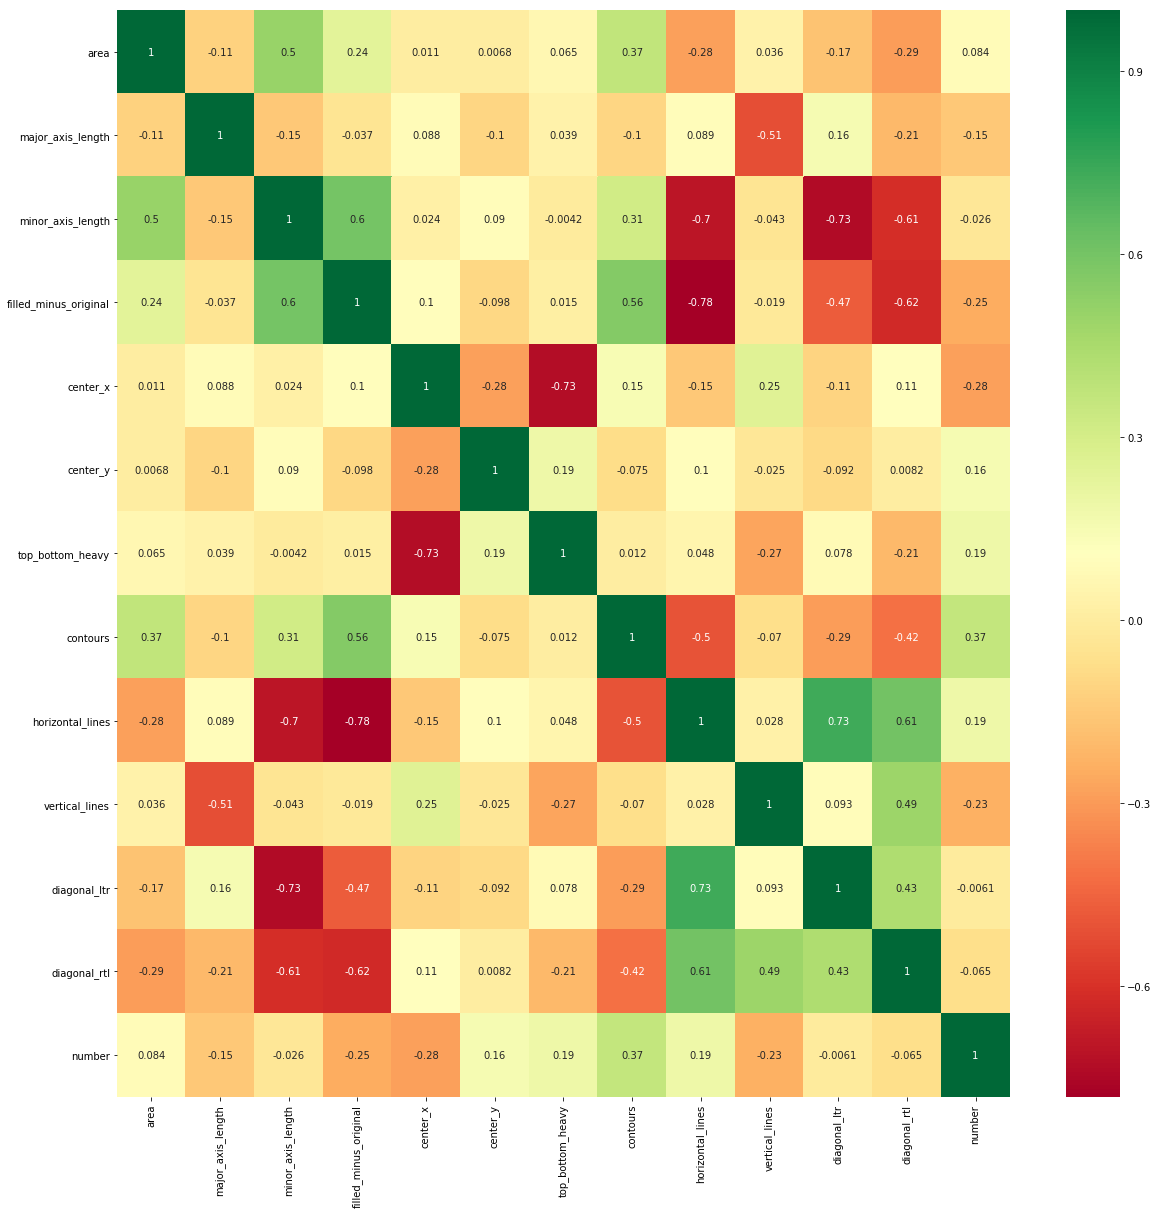

In [27]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, chi2
import random

scaler_pyramid = MinMaxScaler()
scaler_label = MinMaxScaler()
scaler_vision = MinMaxScaler()

X_gaussian = dataset_gausian_pyramid_based.drop(['number'], axis=1).values.astype('float')
X_laplacian = dataset_laplacian_pyramid_based.drop(['number'], axis=1).values.astype('float')
X_pixel = dataset_pixel_based.drop(['number'], axis=1).values.astype('float')
X_vision = dataset_vision_based.drop(['number'], axis=1).values.astype('float')


y_gaussian = dataset_gausian_pyramid_based['number'].values.astype('float') 
y_laplacian = dataset_laplacian_pyramid_based['number'].values.astype('float') 
y_pixel = dataset_pixel_based['number'].values.astype('float') 
y_vision = dataset_vision_based['number'].values.astype('float') 

selector = SelectKBest(chi2, k=10)
X_vision = selector.fit_transform(X_vision, y_vision)


kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_pixel):
    X_train_pixel, X_test_pixel = X_pixel[train_index], X_pixel[test_index]
    y_train_pixel, y_test_pixel = y_pixel[train_index], y_pixel[test_index]
    
for train_index, test_index in kf.split(X_vision):
    X_train_vision, X_test_vision = X_vision[train_index], X_vision[test_index]
    y_train_vision, y_test_vision = y_vision[train_index], y_vision[test_index]

for train_index, test_index in kf.split(X_gaussian):
    X_train_gaussian, X_test_gaussian = X_gaussian[train_index], X_gaussian[test_index]
    y_train_gaussian, y_test_gaussian = y_gaussian[train_index], y_gaussian[test_index]
    
for train_index, test_index in kf.split(X_laplacian):
    X_train_laplacian, X_test_laplacian = X_laplacian[train_index], X_laplacian[test_index]
    y_train_laplacian, y_test_laplacian = y_laplacian[train_index], y_laplacian[test_index]
    
    
print("Done preparing the data")
correlation_matrix = dataset_vision_based.corr()
top_corr_features = correlation_matrix.index
plt.figure(figsize=(20,20))
g=sns.heatmap(dataset_vision_based[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Finding the best parameters for the different datasets and models

Door gebruik te maken van GridSearchCV worden alle uitgekozen classifiers getest met alle mogelijke parameters. Dit zorgt ervoor dat er niet handmatig gekozen hoeft te worden tussen alle verschillende hyperparameters. 

### Best parameters for the Random Forest Regressor

In [54]:
from sklearn.model_selection import GridSearchCV

rf_params = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

grid_search_gaussian_rf = GridSearchCV(RandomForestRegressor(), rf_params,verbose=5, cv=2, n_jobs=-1)
grid_search_laplacian_rf = GridSearchCV(RandomForestRegressor(), rf_params,verbose=5, cv=2, n_jobs=-1)
grid_search_pixel_rf = GridSearchCV(RandomForestRegressor(), rf_params,verbose=5, cv=2, n_jobs=-1)
grid_search_vision_rf = GridSearchCV(RandomForestRegressor(), rf_params,verbose=5, cv=2, n_jobs=-1)

grid_search_gaussian_rf.fit(X_train_gaussian,y_train_gaussian)
grid_search_laplacian_rf.fit(X_train_laplacian,y_train_laplacian)
grid_search_pixel_rf.fit(X_train_pixel,y_train_pixel)
grid_search_vision_rf.fit(X_train_vision,y_train_pixel)

print("Gaussian params",grid_search_gaussian_rf.best_params_)
print("Laplacian params",grid_search_laplacian_rf.best_params_)
print("Pixel params",grid_search_pixel_rf.best_params_)
print("Vision params",grid_search_vision_rf.best_params_)

Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.8min finished


Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.7min finished


Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.4min finished


Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.3min finished


Gaussian params {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 944}
Laplacian params {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1577}
Pixel params {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1155}
Vision params {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 522}


#### Output of grid search

Gaussian params 
{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1336}

Laplacian params 
{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 311}

Pixel params 
{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1155}

Vision params 
{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

### Best parameters for the Multi-layer Perceptron Classifier

In [55]:
from sklearn.neural_network import MLPClassifier
mlp_params= {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid_search_gaussian_mlp = GridSearchCV(MLPClassifier(), mlp_params,verbose=5, cv=2, n_jobs=-1)
grid_search_laplacian_mlp = GridSearchCV(MLPClassifier(), mlp_params,verbose=5, cv=2, n_jobs=-1)
grid_search_pixel_mlp = GridSearchCV(MLPClassifier(), mlp_params,verbose=5, cv=2, n_jobs=-1)
grid_search_vision_mlp = GridSearchCV(MLPClassifier(), mlp_params,verbose=5, cv=2, n_jobs=-1)


grid_search_gaussian_mlp.fit(X_train_gaussian,y_train_gaussian)
grid_search_laplacian_mlp.fit(X_train_laplacian,y_train_laplacian)
grid_search_pixel_mlp.fit(X_train_pixel,y_train_pixel)
grid_search_vision_mlp.fit(X_train_vision,y_train_vision)

print("Gaussian params",grid_search_gaussian_mlp.best_params_)
print("Laplacian params",grid_search_laplacian_mlp.best_params_)
print("pixel params",grid_search_pixel_mlp.best_params_)
print("Vision params",grid_search_vision_mlp.best_params_)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.7min finished


Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.8min finished


Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   45.6s finished
C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   25.7s finished


Gaussian params {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Laplacian params {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
pixel params {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Vision params {'activation': 'logistic', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


#### Output of grid search

Gaussian params 
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}

Laplacian params 
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}

pixel params 
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}

Vision params 
{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}

### Best parameters for the Support Vector Machine

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]}

grid_search_gaussian_svm = GridSearchCV(SVC(), svm_params,verbose=5, cv=2, n_jobs=-1)
grid_search_laplacian_svm = GridSearchCV(SVC(), svm_params,verbose=5, cv=2, n_jobs=-1)
grid_search_pixel_svm = GridSearchCV(SVC(), svm_params,verbose=5, cv=2, n_jobs=-1)
grid_search_vision_svm = GridSearchCV(SVC(), svm_params,verbose=5, cv=2, n_jobs=-1)

grid_search_gaussian_svm.fit(X_train_gaussian,y_train_gaussian)
grid_search_laplacian_svm.fit(X_train_laplacian,y_train_laplacian)
grid_search_pixel_svm.fit(X_train_pixel,y_train_pixel)
grid_search_vision_svm.fit(X_train_vision,y_train_vision)


print("Gaussian params",grid_search_gaussian_svm.best_params_)
print("Laplacian params",grid_search_laplacian_svm.best_params_)
print("Pixel params",grid_search_pixel_svm.best_params_)
print("Vision params",grid_search_vision_svm.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    5.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    5.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.8s finished


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    5.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    5.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.7s finished


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    3.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    3.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.4s finished


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    3.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    3.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished


Gaussian params {'C': 10, 'gamma': 0.01}
Laplacian params {'C': 10, 'gamma': 0.01}
Pixel params {'C': 10, 'gamma': 0.01}
Vision params {'C': 10, 'gamma': 0.001}


#### Output of grid search

Gaussian params 
{'C': 10, 'gamma': 0.01}

Laplacian params 
{'C': 10, 'gamma': 0.01}

Pixel params 
{'C': 10, 'gamma': 0.01}

Vision params 
{'C': 10, 'gamma': 0.001}

### Best parameters for the Decision Tree Classifier

In [57]:
from sklearn.tree import DecisionTreeClassifier

dt_params ={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}

grid_search_gaussian_dt = GridSearchCV(DecisionTreeClassifier(), dt_params,verbose=5, cv=2, n_jobs=-1)
grid_search_laplacian_dt = GridSearchCV(DecisionTreeClassifier(), dt_params,verbose=5, cv=2, n_jobs=-1)
grid_search_pixel_dt = GridSearchCV(DecisionTreeClassifier(), dt_params,verbose=5, cv=2, n_jobs=-1)
grid_search_vision_dt = GridSearchCV(DecisionTreeClassifier(), dt_params,verbose=5, cv=2, n_jobs=-1)


grid_search_gaussian_dt.fit(X_train_gaussian,y_train_gaussian)
grid_search_laplacian_dt.fit(X_train_laplacian,y_train_laplacian)
grid_search_pixel_dt.fit(X_train_pixel,y_train_pixel)
grid_search_vision_dt.fit(X_train_vision,y_train_vision)

print("Gaussian params",grid_search_gaussian_dt.best_params_)
print("Laplacian params",grid_search_laplacian_dt.best_params_)
print("Pixel params",grid_search_pixel_dt.best_params_)
print("Vision params",grid_search_vision_dt.best_params_)

Fitting 2 folds for each of 250 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.7s finished


Fitting 2 folds for each of 250 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.7s finished


Fitting 2 folds for each of 250 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.2s finished


Fitting 2 folds for each of 250 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.9s


Gaussian params {'max_depth': 17, 'min_samples_split': 10}
Laplacian params {'max_depth': 11, 'min_samples_split': 10}
Pixel params {'max_depth': 7, 'min_samples_split': 10}
Vision params {'max_depth': 17, 'min_samples_split': 10}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.2s finished


#### Output of grid search

Gaussian params 
{'max_depth': 17, 'min_samples_split': 10}

Laplacian params 
{'max_depth': 15, 'min_samples_split': 10}

Pixel params 
{'max_depth': 7, 'min_samples_split': 10}

Vision params
{'max_depth': 19, 'min_samples_split': 10}


### Best parameters for the Naive Bayes Classifier

In [58]:
from sklearn.naive_bayes import MultinomialNB

nb_params = {'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001) }

grid_search_gaussian_nb = GridSearchCV(MultinomialNB(), nb_params,verbose=5, cv=2, n_jobs=-1)
grid_search_laplacian_nb = GridSearchCV(MultinomialNB(), nb_params,verbose=5, cv=2, n_jobs=-1)
grid_search_pixel_nb = GridSearchCV(MultinomialNB(), nb_params,verbose=5, cv=2, n_jobs=-1)
grid_search_vision_nb = GridSearchCV(MultinomialNB(), nb_params,verbose=5, cv=2, n_jobs=-1)


grid_search_gaussian_nb.fit(X_train_gaussian,y_train_gaussian)
grid_search_laplacian_nb.fit(X_train_laplacian,y_train_laplacian)
grid_search_pixel_nb.fit(X_train_pixel,y_train_pixel)
grid_search_vision_nb.fit(X_train_vision,y_train_vision)

print("Gaussian params",grid_search_gaussian_nb.best_params_)
print("Laplacian params",grid_search_laplacian_nb.best_params_)
print("Pixel params",grid_search_pixel_nb.best_params_)
print("Vision params",grid_search_pixel_nb.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    1.2s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.7s finished


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    1.2s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.7s finished


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    1.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.8s finished


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    1.2s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    2.3s remaining:    0.4s


Gaussian params {'alpha': 1}
Laplacian params {'alpha': 0.1}
Pixel params {'alpha': 1}
Vision params {'alpha': 1}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.7s finished


#### Output of grid search

Gaussian params 
{'alpha': 1}

Laplacian params 
{'alpha': 0.1}

Pixel params 
{'alpha': 1}

Vision params 
{'alpha': 1}

### Best parameters for the KNeighbors Classifier

In [59]:
from sklearn.neighbors import KNeighborsClassifier

kn_params ={'n_neighbors' : range(1,20,1),'metric':['cosine'],'weights':['distance']}

grid_search_gaussian_kn = GridSearchCV(KNeighborsClassifier(), kn_params,verbose=5, cv=2, n_jobs=-1)
grid_search_laplacian_kn = GridSearchCV(KNeighborsClassifier(), kn_params,verbose=5, cv=2, n_jobs=-1)
grid_search_pixel_kn = GridSearchCV(KNeighborsClassifier(), kn_params,verbose=5, cv=2, n_jobs=-1)
grid_search_vision_kn = GridSearchCV(KNeighborsClassifier(), kn_params,verbose=5, cv=2, n_jobs=-1)


grid_search_gaussian_kn.fit(X_train_gaussian,y_train_gaussian)
grid_search_laplacian_kn.fit(X_train_laplacian,y_train_laplacian)
grid_search_pixel_kn.fit(X_train_pixel,y_train_pixel)
grid_search_vision_kn.fit(X_train_vision,y_train_vision)

print("Gaussian params",grid_search_gaussian_kn.best_params_)
print("Laplacian params",grid_search_laplacian_kn.best_params_)
print("Pixel params",grid_search_pixel_kn.best_params_)
print("Vision params",grid_search_vision_kn.best_params_)

Fitting 2 folds for each of 19 candidates, totalling 38 fits


[Parallel(n_jobs=-1)]: Done  23 out of  38 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:    3.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    3.6s finished


Fitting 2 folds for each of 19 candidates, totalling 38 fits


[Parallel(n_jobs=-1)]: Done  23 out of  38 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:    3.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    3.6s finished


Fitting 2 folds for each of 19 candidates, totalling 38 fits


[Parallel(n_jobs=-1)]: Done  23 out of  38 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:    3.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    3.0s finished


Fitting 2 folds for each of 19 candidates, totalling 38 fits
Gaussian params {'metric': 'cosine', 'n_neighbors': 4, 'weights': 'distance'}
Laplacian params {'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}
Pixel params {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}
Vision params {'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done  23 out of  38 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:    3.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    3.0s finished


#### Output of grid search

Gaussian params 
{'metric': 'cosine', 'n_neighbors': 4, 'weights': 'distance'}

Laplacian params 
{'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}

Pixel params 
{'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}

Vision params 
{'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}

# Training the different models on the datasets

Door alle verschillende classifiers met de beste hyperparameters op de gesorteerde training data te fitten en te testen wordt het duidelijk welke classifier het beste scoort. Daarnaast wordt in dit hoofdstuk gebruik gemaakt van pipelines en verschillende bagging en ensemble models. 

### Random Forest Regressor

RF Gaussian Classifier:		 0.8660802018757668
RF Laplacian Classifier:	 0.8768344895881625
RF pixel Classifier:		 0.8321478524355856
RF vision Classifier:		 0.8277205099993528


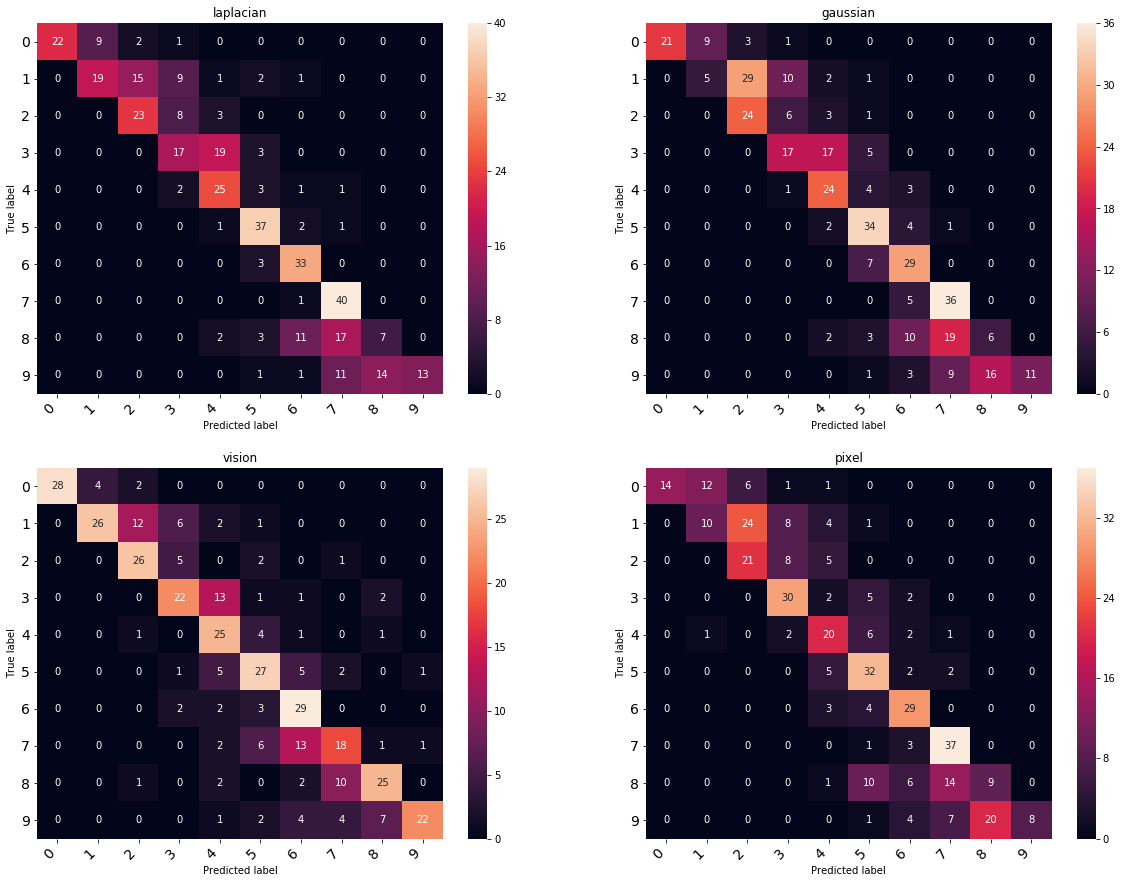

In [28]:
rf_gaussian_model = RandomForestRegressor(random_state=0,n_estimators= 1336,min_samples_split= 2,min_samples_leaf= 1,max_features='sqrt', max_depth= None, bootstrap= False)
rf_laplacian_model = RandomForestRegressor(random_state=0,n_estimators= 1336,min_samples_split= 2,min_samples_leaf= 1,max_features='sqrt', max_depth= None, bootstrap= False)
rf_pixel_model = RandomForestRegressor(random_state=0,n_estimators= 1155,min_samples_split= 2,min_samples_leaf= 1,max_features='sqrt', max_depth= None, bootstrap= False)
rf_vision_model = RandomForestRegressor(random_state=0,n_estimators= 100,min_samples_split= 2,min_samples_leaf= 1,max_features='sqrt', max_depth= None, bootstrap= False)


pipe_gaussian_rf = Pipeline([('scaler', scaler_pyramid),('classifier', rf_gaussian_model)])
pipe_laplacian_rf = Pipeline([('scaler', scaler_pyramid),('classifier', rf_laplacian_model)])
pipe_pixel_rf = Pipeline([('scaler', scaler_label),('classifier', rf_pixel_model)])
pipe_vision_rf = Pipeline([('scaler', scaler_vision),('classifier', rf_vision_model)])


pipe_gaussian_rf.fit(X_train_gaussian,y_train_gaussian)
pipe_laplacian_rf.fit(X_train_laplacian,y_train_laplacian)
pipe_pixel_rf.fit(X_train_pixel,y_train_pixel)
pipe_vision_rf.fit(X_train_vision,y_train_vision)

prediction_lap = pipe_laplacian_rf.predict(X_test_laplacian)
prediction_gau = pipe_gaussian_rf.predict(X_test_gaussian)
prediction_vis = pipe_vision_rf.predict(X_test_vision)
prediction_pix = pipe_pixel_rf.predict(X_test_pixel)
# print(prediction_lap)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)
for index, dataset_name in enumerate(['laplacian','gaussian','vision','pixel']):
        ax[int(index/2)][index%2].set_title(dataset_name)
prediction_lap = np.around(prediction_lap)
prediction_gau = np.around(prediction_gau)
prediction_vis= np.around(prediction_vis)
prediction_pix = np.around(prediction_pix)

print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])


print("RF Gaussian Classifier:\t\t",pipe_gaussian_rf.score(X_test_gaussian,y_test_gaussian))
print("RF Laplacian Classifier:\t",pipe_laplacian_rf.score(X_test_laplacian,y_test_laplacian))
print("RF pixel Classifier:\t\t",pipe_pixel_rf.score(X_test_pixel,y_test_pixel))
print("RF vision Classifier:\t\t",pipe_vision_rf.score(X_test_vision,y_test_vision))

### Multi-layer Perceptron classifier

Een multi layer perceptron is een neural network die meerdere lagen verbind in een directed graph. Dit betekend dat de data maar op 1 manier door de verschillende lagen heen gaat. MLP gebruikt back propagation bij het supervised learning

MLP Gaussian Classifier:	 0.953125
MLP Laplacian Classifier:	 0.9609375
MLP pixel Classifier:		 0.9348958333333334
MLP vision Classifier:		 0.8854166666666666


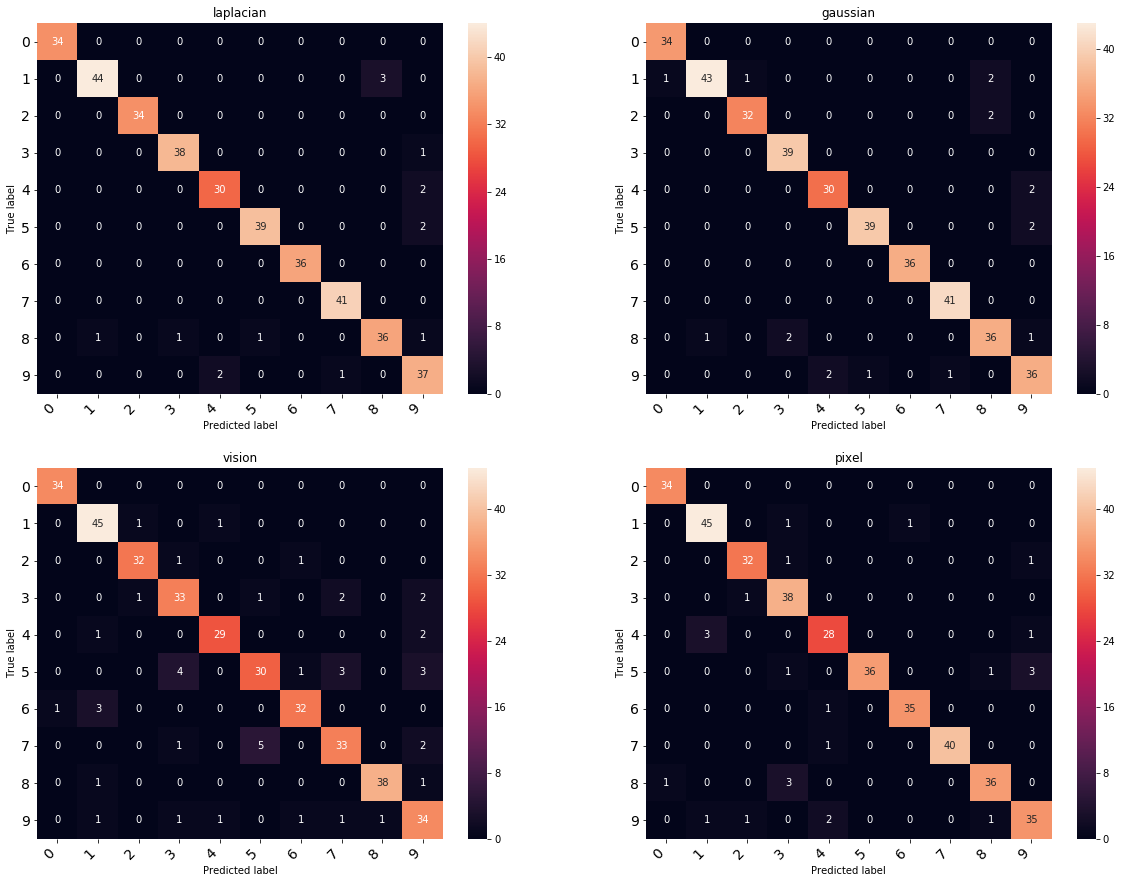

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

mlp_gaussian_model = MLPClassifier(solver='adam',hidden_layer_sizes=(100),learning_rate='constant', activation='relu', max_iter = 300)
mlp_laplacian_model = MLPClassifier(solver='adam',hidden_layer_sizes=(100),learning_rate='constant', activation='logistic', max_iter = 300)
mlp_pixel_model = MLPClassifier(solver='adam',hidden_layer_sizes=(100),learning_rate='constant', activation='tanh', max_iter = 1000)
mlp_vision_model = MLPClassifier(solver='adam',hidden_layer_sizes=(100),learning_rate='adaptive', activation='logistic', max_iter = 1000)

pipe_gaussian_mlp = Pipeline([('scaler', scaler_pyramid),('classifier', mlp_gaussian_model)])
pipe_laplacian_mlp = Pipeline([('scaler', scaler_pyramid),('classifier', mlp_laplacian_model)])
pipe_pixel_mlp = Pipeline([('scaler', scaler_label),('classifier', mlp_pixel_model)])
pipe_vision_mlp = Pipeline([('scaler', scaler_vision),('classifier', mlp_vision_model)])

pipe_gaussian_mlp.fit(X_train_gaussian,y_train_gaussian)
pipe_laplacian_mlp.fit(X_train_laplacian,y_train_laplacian)
pipe_pixel_mlp.fit(X_train_pixel,y_train_pixel)
pipe_vision_mlp.fit(X_train_vision,y_train_vision)

prediction_lap = pipe_laplacian_mlp.predict(X_test_laplacian)
prediction_gau = pipe_gaussian_mlp.predict(X_test_gaussian)
prediction_vis = pipe_vision_mlp.predict(X_test_vision)
prediction_pix = pipe_pixel_mlp.predict(X_test_pixel)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)
for index, dataset_name in enumerate(['laplacian','gaussian','vision','pixel']):
        ax[int(index/2)][index%2].set_title(dataset_name)

print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])

print("MLP Gaussian Classifier:\t",pipe_gaussian_mlp.score(X_test_gaussian,y_test_gaussian))
print("MLP Laplacian Classifier:\t",pipe_laplacian_mlp.score(X_test_laplacian,y_test_laplacian))
print("MLP pixel Classifier:\t\t",pipe_pixel_mlp.score(X_test_pixel,y_test_pixel))
print("MLP vision Classifier:\t\t",pipe_vision_mlp.score(X_test_vision,y_test_vision))


### Support Vector Machine

SVC Gaussian Classifier:	 0.9765625
SVC Laplacian Classifier:	 0.9869791666666666
SVC pixel Classifier:		 0.9635416666666666
SVC vision Classifier:		 0.90625


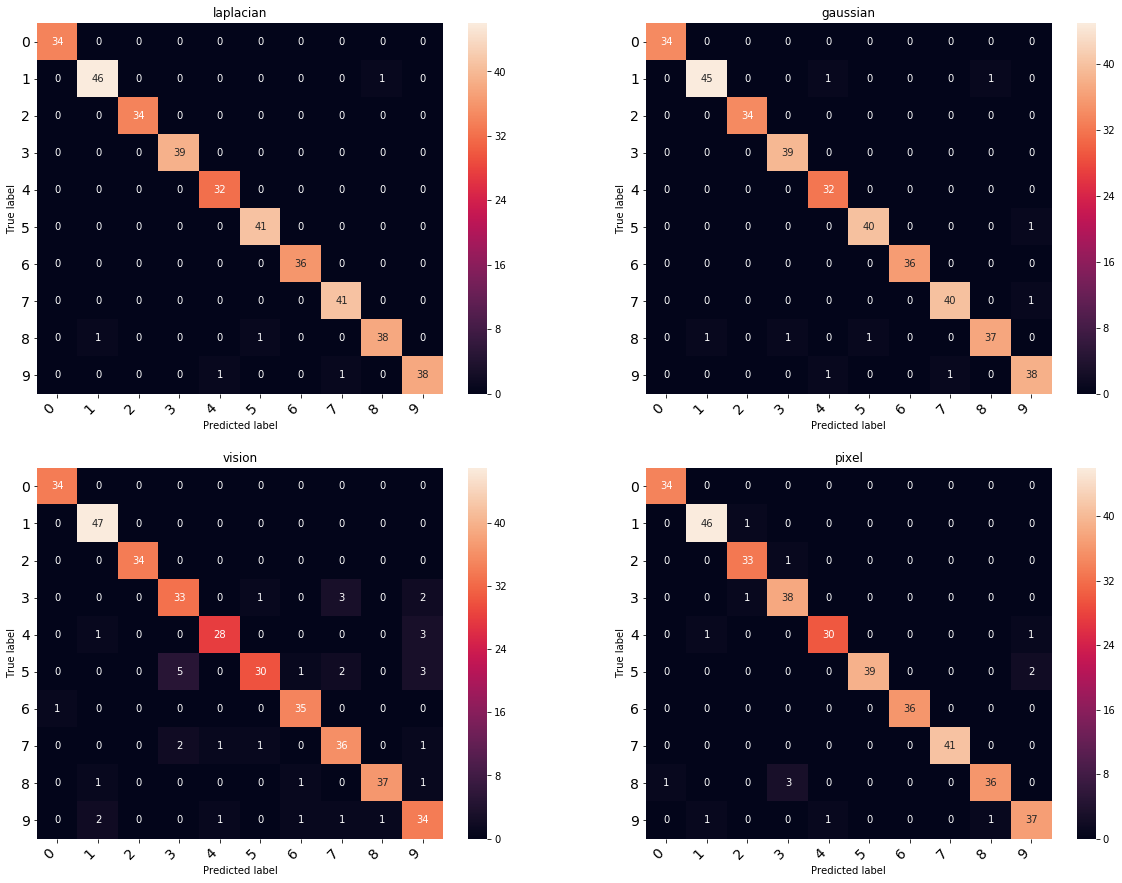

In [30]:
from sklearn.svm import SVC

svclassifier_gaussian = SVC(C= 10, gamma=0.01,kernel='rbf')
svclassifier_laplacian = SVC(C= 10, gamma=0.01,kernel='rbf')
svclassifier_pixel = SVC(C= 10, gamma= 1, kernel= 'rbf')
svclassifier_vision = SVC(C= 10, gamma= 1, kernel= 'rbf')

svclassifier_gaussian_model = BaggingClassifier(base_estimator=svclassifier_gaussian,n_estimators=31,random_state=0)
svclassifier_laplacian_model = BaggingClassifier(base_estimator=svclassifier_laplacian,n_estimators=31,random_state=0)
svclassifier_pixel_model = BaggingClassifier(base_estimator=svclassifier_pixel,n_estimators=31,random_state=0)
svclassifier_vision_model = BaggingClassifier(base_estimator=svclassifier_vision,n_estimators=31,random_state=0)

pipe_gaussian_svm = Pipeline([('scaler', scaler_pyramid),('classifier', svclassifier_gaussian_model)])
pipe_laplacian_svm = Pipeline([('scaler', scaler_pyramid),('classifier', svclassifier_laplacian_model)])
pipe_pixel_svm = Pipeline([('scaler', scaler_label),('classifier', svclassifier_pixel_model)])
pipe_vision_svm = Pipeline([('scaler', scaler_vision),('classifier', svclassifier_vision_model)])


pipe_gaussian_svm.fit(X_train_gaussian,y_train_gaussian)
pipe_laplacian_svm.fit(X_train_laplacian,y_train_laplacian)
pipe_pixel_svm.fit(X_train_pixel,y_train_pixel)
pipe_vision_svm.fit(X_train_vision,y_train_vision)

prediction_lap = pipe_laplacian_svm.predict(X_test_laplacian)
prediction_gau = pipe_gaussian_svm.predict(X_test_gaussian)
prediction_vis = pipe_vision_svm.predict(X_test_vision)
prediction_pix = pipe_pixel_svm.predict(X_test_pixel)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)
for index, dataset_name in enumerate(['laplacian','gaussian','vision','pixel']):
        ax[int(index/2)][index%2].set_title(dataset_name)

print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])

print("SVC Gaussian Classifier:\t",pipe_gaussian_svm.score(X_test_gaussian,y_test_gaussian))
print("SVC Laplacian Classifier:\t",pipe_laplacian_svm.score(X_test_laplacian,y_test_laplacian))
print("SVC pixel Classifier:\t\t",pipe_pixel_svm.score(X_test_pixel,y_test_pixel))
print("SVC vision Classifier:\t\t",pipe_vision_svm.score(X_test_vision,y_test_vision))

### Ridge Classifier

De ridge classifier gebruikt een Ridge regression model om een classifier te maken. Een Ridge classifier is goed te gebruiken wanneer er veel features bestaan zoals bijvoorbeeld bij een text classification model. Dit komt omdat veel features meestal goed linear te verdelen zijn en de ridge classifier dit goed kan. 

Ridge Gaussian Model:	 0.9192708333333334
Ridge Laplacian Model:	 0.9036458333333334
Ridge pixel Model:	 0.890625
Ridge vision Model:	 0.7447916666666666


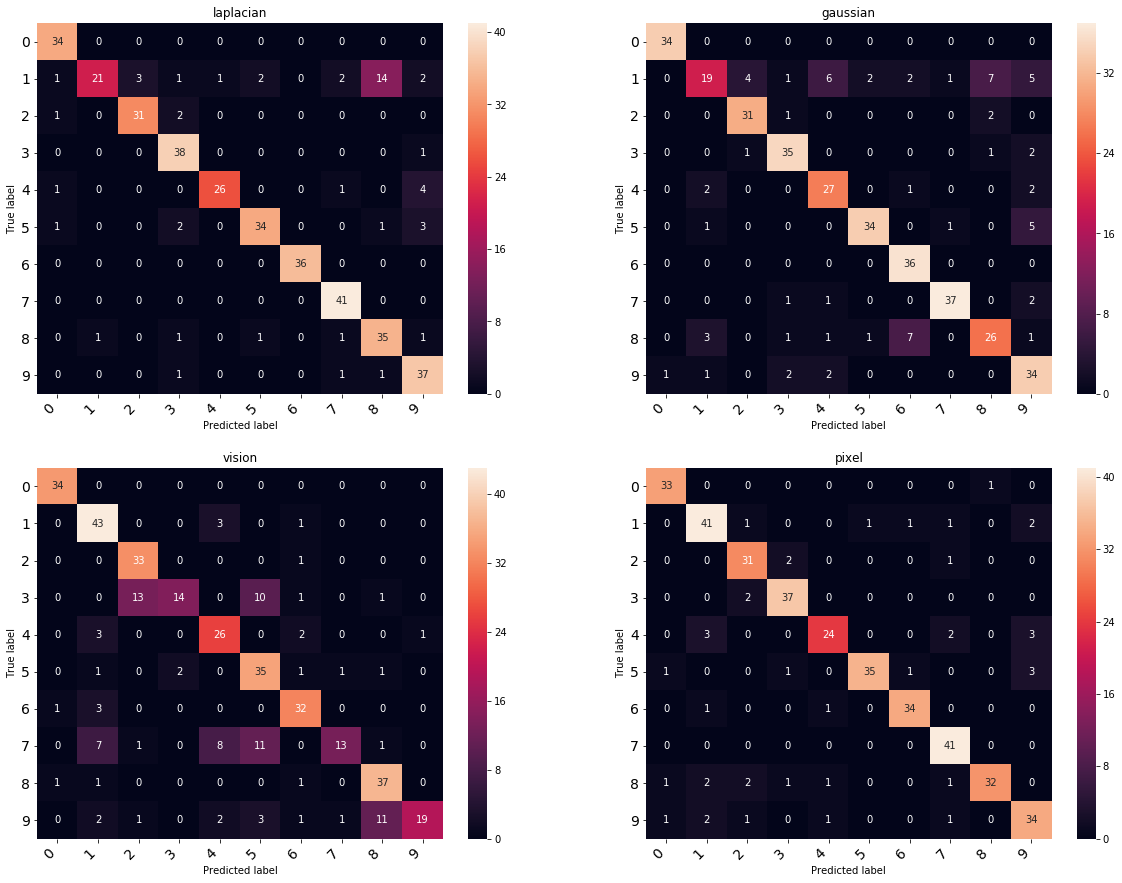

In [31]:
from sklearn.linear_model import RidgeClassifier

ridge_gaussian_classifier = RidgeClassifier()
ridge_laplacian_classifier = RidgeClassifier()
ridge_pixel_classifier = RidgeClassifier()
ridge_vision_classifier = RidgeClassifier()

pipe_gaussian_ridge = Pipeline([('scaler', scaler_pyramid),('classifier', ridge_gaussian_classifier)])
pipe_laplacian_ridge = Pipeline([('scaler', scaler_pyramid),('classifier', ridge_laplacian_classifier)])
pipe_pixel_ridge = Pipeline([('scaler', scaler_label),('classifier', ridge_pixel_classifier)])
pipe_vision_ridge = Pipeline([('scaler', scaler_vision),('classifier', ridge_vision_classifier)])

pipe_gaussian_ridge.fit(X_train_gaussian,y_train_gaussian)
pipe_laplacian_ridge.fit(X_train_laplacian,y_train_laplacian)
pipe_pixel_ridge.fit(X_train_pixel,y_train_pixel)
pipe_vision_ridge.fit(X_train_vision,y_train_vision)

prediction_lap = pipe_gaussian_ridge.predict(X_test_laplacian)
prediction_gau = pipe_laplacian_ridge.predict(X_test_gaussian)
prediction_vis = pipe_vision_ridge.predict(X_test_vision)
prediction_pix = pipe_pixel_ridge.predict(X_test_pixel)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)
for index, dataset_name in enumerate(['laplacian','gaussian','vision','pixel']):
        ax[int(index/2)][index%2].set_title(dataset_name)

print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])

print("Ridge Gaussian Model:\t",pipe_gaussian_ridge.score(X_test_gaussian,y_test_gaussian))
print("Ridge Laplacian Model:\t",pipe_laplacian_ridge.score(X_test_laplacian,y_test_laplacian))
print("Ridge pixel Model:\t",pipe_pixel_ridge.score(X_test_pixel,y_test_pixel))
print("Ridge vision Model:\t",pipe_vision_ridge.score(X_test_vision,y_test_vision))

### Decision Tree Classifier

DT Gaussian Model:	 0.8307291666666666
DT Laplacian Model:	 0.8411458333333334
DT pixel Model:		 0.8072916666666666
DT vision Model:	 0.8125


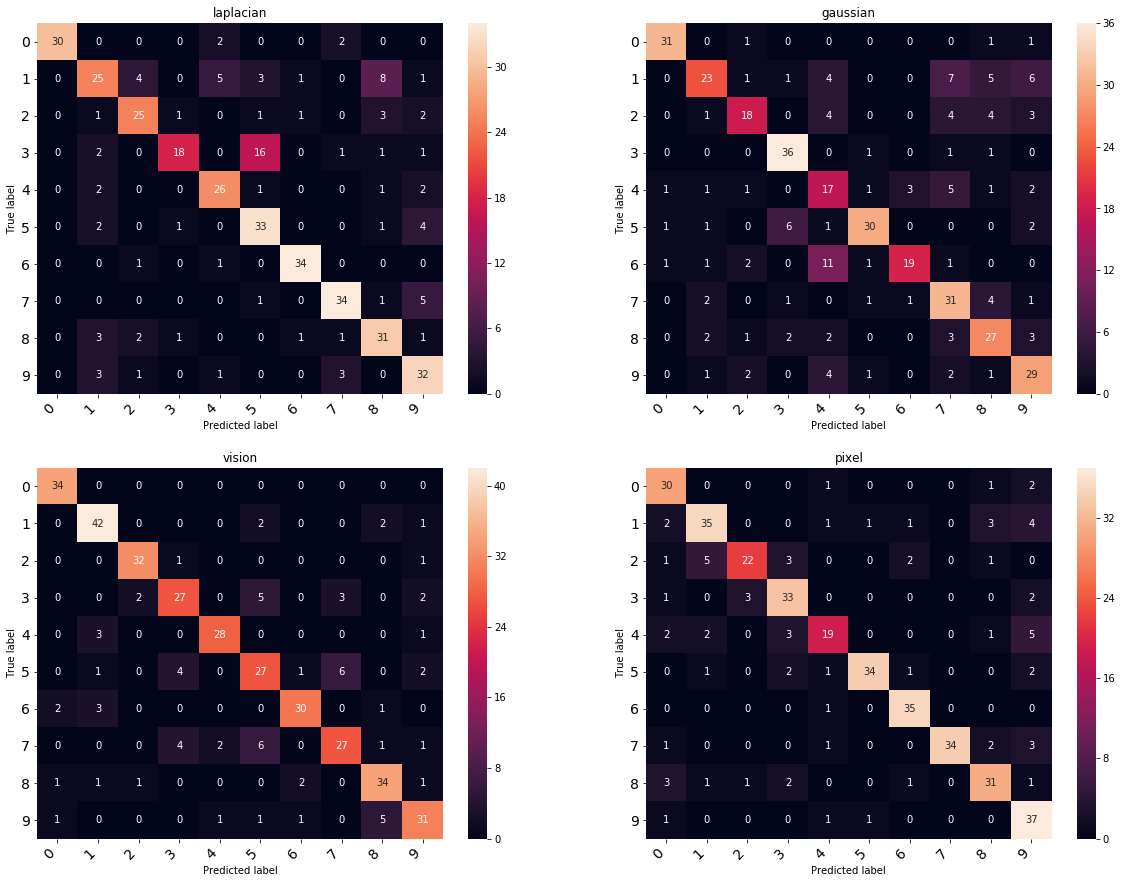

In [32]:
from sklearn.tree import DecisionTreeClassifier

dt_gaussian_classifier = DecisionTreeClassifier(max_depth=17, min_samples_split=10)
dt_laplacian_classifier = DecisionTreeClassifier(max_depth=15, min_samples_split=10)
dt_pixel_classifier = DecisionTreeClassifier(max_depth=19, min_samples_split=10)
dt_vision_classifier = DecisionTreeClassifier(max_depth=19, min_samples_split=10)

pipe_gaussian_dt = Pipeline([('scaler', scaler_pyramid),('classifier', dt_gaussian_classifier)])
pipe_laplacian_dt = Pipeline([('scaler', scaler_pyramid),('classifier', dt_laplacian_classifier)])
pipe_pixel_dt = Pipeline([('scaler', scaler_label),('classifier', dt_pixel_classifier)])
pipe_vision_dt = Pipeline([('scaler', scaler_vision),('classifier', dt_vision_classifier)])

pipe_gaussian_dt.fit(X_train_gaussian,y_train_gaussian)
pipe_laplacian_dt.fit(X_train_laplacian,y_train_laplacian)
pipe_pixel_dt.fit(X_train_pixel,y_train_pixel)
pipe_vision_dt.fit(X_train_vision,y_train_vision)

prediction_lap = pipe_gaussian_dt.predict(X_test_laplacian)
prediction_gau = pipe_laplacian_dt.predict(X_test_gaussian)
prediction_vis = pipe_vision_dt.predict(X_test_vision)
prediction_pix = pipe_pixel_dt.predict(X_test_pixel)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)
for index, dataset_name in enumerate(['laplacian','gaussian','vision','pixel']):
        ax[int(index/2)][index%2].set_title(dataset_name)

print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])

print("DT Gaussian Model:\t",pipe_gaussian_dt.score(X_test_gaussian,y_test_gaussian))
print("DT Laplacian Model:\t",pipe_laplacian_dt.score(X_test_laplacian,y_test_laplacian))
print("DT pixel Model:\t\t",pipe_pixel_dt.score(X_test_pixel,y_test_pixel))
print("DT vision Model:\t",pipe_vision_dt.score(X_test_vision,y_test_vision))

### Naive Bayes Classifier

NB Gaussian Model:	 0.8854166666666666
NB Laplacian Model:	 0.8984375
NB pixel Model:		 0.7942708333333334
NB vision Model:	 0.6796875


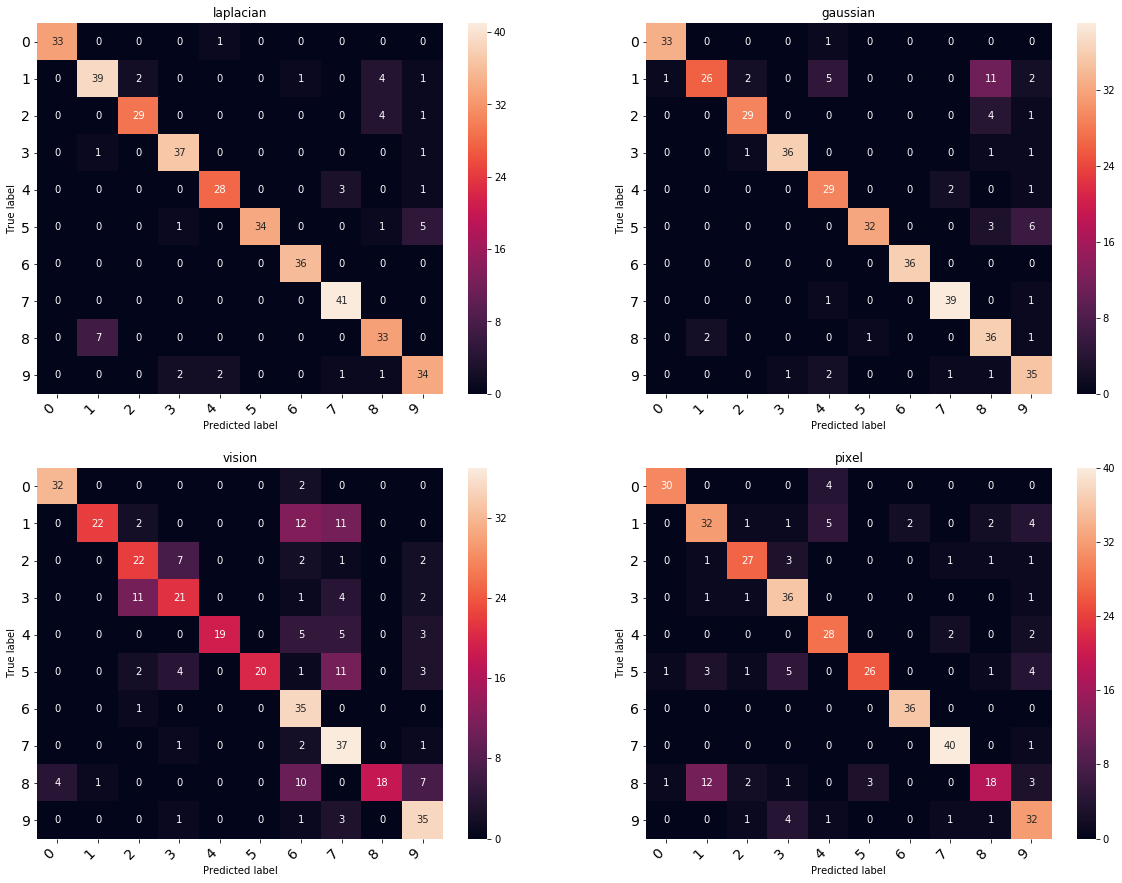

In [33]:
from sklearn.naive_bayes import MultinomialNB

nb_gaussian_model = MultinomialNB(alpha=1)
nb_laplacian_model = MultinomialNB(alpha=0.1)
nb_pixel_model = MultinomialNB(alpha=1)
nb_vision_model = MultinomialNB(alpha=1)

pipe_gaussian_nb = Pipeline([('scaler', scaler_pyramid),('classifier', nb_gaussian_model)])
pipe_laplacian_nb = Pipeline([('scaler', scaler_pyramid),('classifier', nb_laplacian_model)])
pipe_pixel_nb = Pipeline([('scaler', scaler_label),('classifier', nb_pixel_model)])
pipe_vision_nb = Pipeline([('scaler', scaler_vision),('classifier', nb_vision_model)])


pipe_gaussian_nb.fit(X_train_gaussian,y_train_gaussian)
pipe_laplacian_nb.fit(X_train_laplacian,y_train_laplacian)
pipe_pixel_nb.fit(X_train_pixel,y_train_pixel)
pipe_vision_nb.fit(X_train_vision,y_train_vision)

prediction_lap = pipe_gaussian_nb.predict(X_test_laplacian)
prediction_gau = pipe_laplacian_nb.predict(X_test_gaussian)
prediction_vis = pipe_vision_nb.predict(X_test_vision)
prediction_pix = pipe_pixel_nb.predict(X_test_pixel)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)
for index, dataset_name in enumerate(['laplacian','gaussian','vision','pixel']):
        ax[int(index/2)][index%2].set_title(dataset_name)

print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])


print("NB Gaussian Model:\t",pipe_gaussian_nb.score(X_test_gaussian,y_test_gaussian))
print("NB Laplacian Model:\t",pipe_laplacian_nb.score(X_test_laplacian,y_test_laplacian))
print("NB pixel Model:\t\t",pipe_pixel_nb.score(X_test_pixel,y_test_pixel))
print("NB vision Model:\t",pipe_vision_nb.score(X_test_vision,y_test_vision))

### KNeighbors Classifier

Gaussian Model:		 0.96875
Laplacian Model:	 0.9791666666666666
pixel Model:		 0.921875
vision Model:		 0.8828125


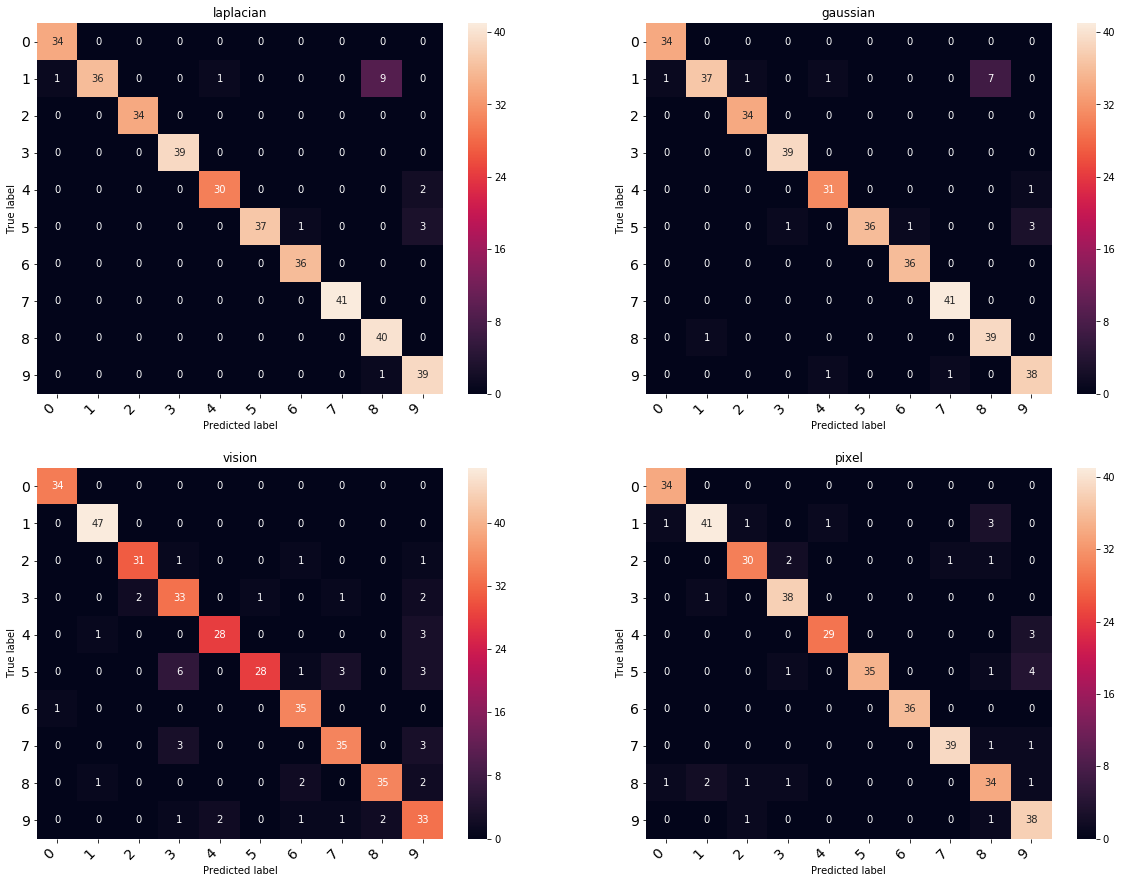

In [34]:
from sklearn.neighbors import KNeighborsClassifier

kclassifier_gaussian = KNeighborsClassifier(metric= 'cosine', n_neighbors= 4, weights= 'distance')
kclassifier_laplacian = KNeighborsClassifier(metric= 'cosine', n_neighbors=3, weights= 'distance')
kclassifier_pixel = KNeighborsClassifier(metric= 'cosine', n_neighbors= 5, weights= 'distance')
kclassifier_vision = KNeighborsClassifier(metric= 'cosine', n_neighbors= 4, weights= 'distance')


kclassifier_gaussian_model = BaggingClassifier(base_estimator=kclassifier_gaussian,n_estimators= 31,random_state=0)
kclassifier_laplacian_model = BaggingClassifier(base_estimator=kclassifier_laplacian,n_estimators= 31,random_state=0)
kclassifier_pixel_model = BaggingClassifier(base_estimator=kclassifier_pixel,n_estimators= 31,random_state=0)
kclassifier_vision_model = BaggingClassifier(base_estimator=kclassifier_vision,n_estimators= 31,random_state=0)

pipe_gaussian_kn = Pipeline([('scaler', scaler_pyramid),('classifier', kclassifier_gaussian_model)])
pipe_laplacian_kn = Pipeline([('scaler', scaler_pyramid),('classifier', kclassifier_laplacian_model)])
pipe_pixel_kn = Pipeline([('scaler', scaler_label),('classifier', kclassifier_pixel_model)]) 
pipe_vision_kn = Pipeline([('scaler', scaler_vision),('classifier', kclassifier_vision_model)])

pipe_gaussian_kn.fit(X_train_gaussian,y_train_gaussian)
pipe_laplacian_kn.fit(X_train_laplacian,y_train_laplacian)
pipe_pixel_kn.fit(X_train_pixel,y_train_pixel)
pipe_vision_kn.fit(X_train_vision,y_train_vision)

prediction_lap = pipe_gaussian_kn.predict(X_test_laplacian)
prediction_gau = pipe_laplacian_kn.predict(X_test_gaussian)
prediction_vis = pipe_vision_kn.predict(X_test_vision)
prediction_pix = pipe_pixel_kn.predict(X_test_pixel)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)
for index, dataset_name in enumerate(['laplacian','gaussian','vision','pixel']):
        ax[int(index/2)][index%2].set_title(dataset_name)

print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])


print("Gaussian Model:\t\t",pipe_gaussian_kn.score(X_test_gaussian,y_test_gaussian))
print("Laplacian Model:\t",pipe_laplacian_kn.score(X_test_laplacian,y_test_laplacian))
print("pixel Model:\t\t",pipe_pixel_kn.score(X_test_pixel,y_test_pixel))
print("vision Model:\t\t",pipe_vision_kn.score(X_test_vision,y_test_vision))

# Final votingclassifier model

C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Gaussian 0.9817708333333334


C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Laplacian 0.9869791666666666


C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Pixel 0.953125


C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Vision 0.9036458333333334


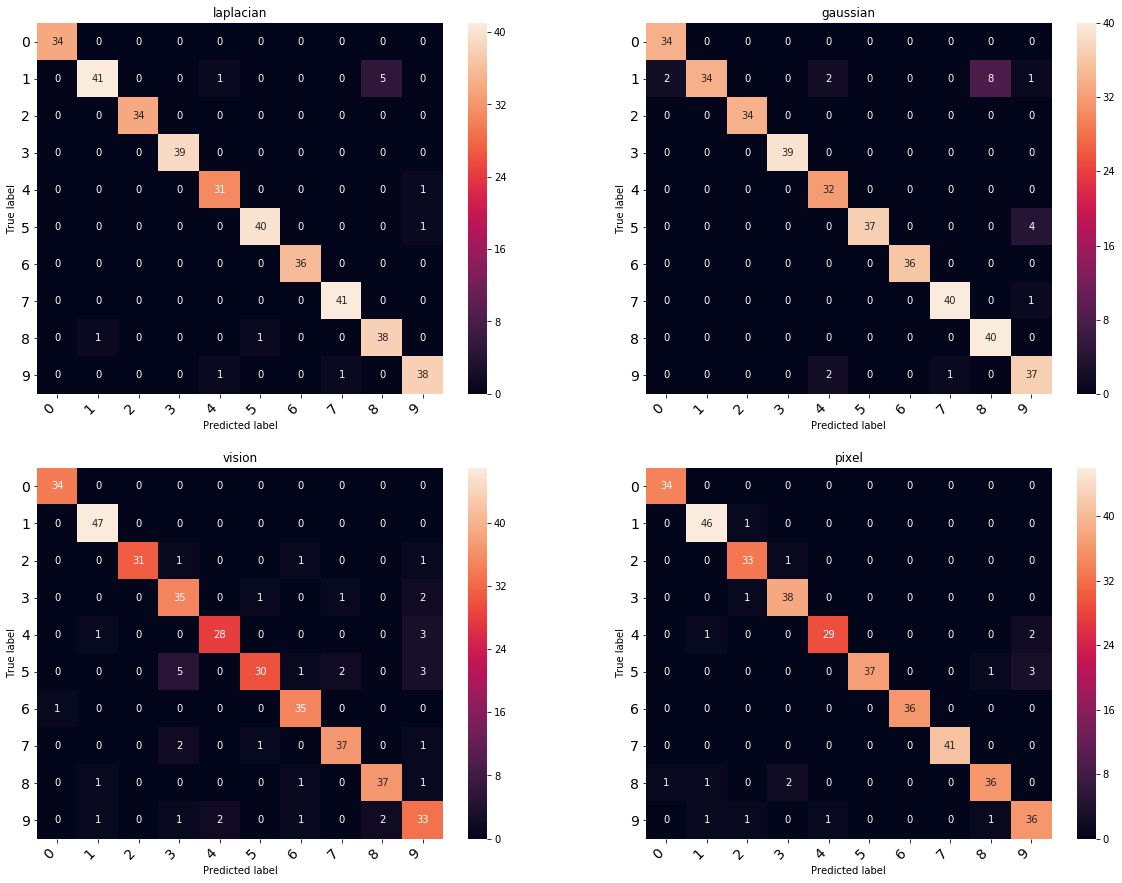

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
estimators_gaussian =[('knn', clone(pipe_gaussian_kn)),('mlp',clone(pipe_gaussian_mlp)),('svm',clone(pipe_gaussian_svm)),('nb',clone(pipe_gaussian_nb))]
estimators_laplacian =[('knn', clone(pipe_laplacian_kn)),('mlp',clone(pipe_laplacian_mlp)),('svm',clone(pipe_laplacian_svm)),('nb',clone(pipe_laplacian_nb))]
estimators_pixel =[('knn', clone(pipe_pixel_kn)),('mlp',clone(pipe_pixel_mlp)),('svm',clone(pipe_pixel_svm))]
estimators_vision =[('knn', clone(pipe_vision_kn)),('mlp',clone(pipe_vision_mlp)),('svm',clone(pipe_vision_svm))]

ensemble_gaussian = VotingClassifier(estimators_gaussian, voting='hard')
ensemble_laplacian = VotingClassifier(estimators_laplacian, voting='hard')
ensemble_pixel = VotingClassifier(estimators_pixel, voting='hard')
ensemble_vision = VotingClassifier(estimators_vision, voting='hard')

ensemble_gaussian.fit(X_train_gaussian,y_train_gaussian)
ensemble_laplacian.fit(X_train_laplacian,y_train_laplacian)
ensemble_pixel.fit(X_train_pixel,y_train_pixel)
ensemble_vision.fit(X_train_vision,y_train_vision)

prediction_lap = ensemble_gaussian.predict(X_test_laplacian)
prediction_gau = ensemble_laplacian.predict(X_test_gaussian)
prediction_vis = ensemble_vision.predict(X_test_vision)
prediction_pix = ensemble_pixel.predict(X_test_pixel)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)
for index, dataset_name in enumerate(['laplacian','gaussian','vision','pixel']):
        ax[int(index/2)][index%2].set_title(dataset_name)

print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])


print('Gaussian',ensemble_gaussian.score(X_test_gaussian, y_test_gaussian))
print('Laplacian',ensemble_laplacian.score(X_test_laplacian, y_test_laplacian))
print('Pixel',ensemble_pixel.score(X_test_pixel, y_test_pixel))
print('Vision',ensemble_vision.score(X_test_vision, y_test_vision))




# Comparison between the datasets using confusion matrix and classification reports

Door de verschillende models te vergelijken door middel van de confusion matrices en classification reports. Wordt het duidelijk waar de verschillende datasets en verschillende classifiers goed en/of slecht in zijn. Met behulp van deze conclusie wordt het duidelijk wat de voor en nadelen zijn.

Laplacian dataset
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        34
        1.0       0.98      0.87      0.92        47
        2.0       1.00      1.00      1.00        34
        3.0       1.00      1.00      1.00        39
        4.0       0.94      0.97      0.95        32
        5.0       0.98      0.98      0.98        41
        6.0       1.00      1.00      1.00        36
        7.0       0.98      1.00      0.99        41
        8.0       0.88      0.95      0.92        40
        9.0       0.95      0.95      0.95        40

avg / total       0.97      0.97      0.97       384

Gaussian dataset
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97        34
        1.0       1.00      0.72      0.84        47
        2.0       1.00      1.00      1.00        34
        3.0       1.00      1.00      1.00        39
        4.0       0.89      1.00      0.94        32
       

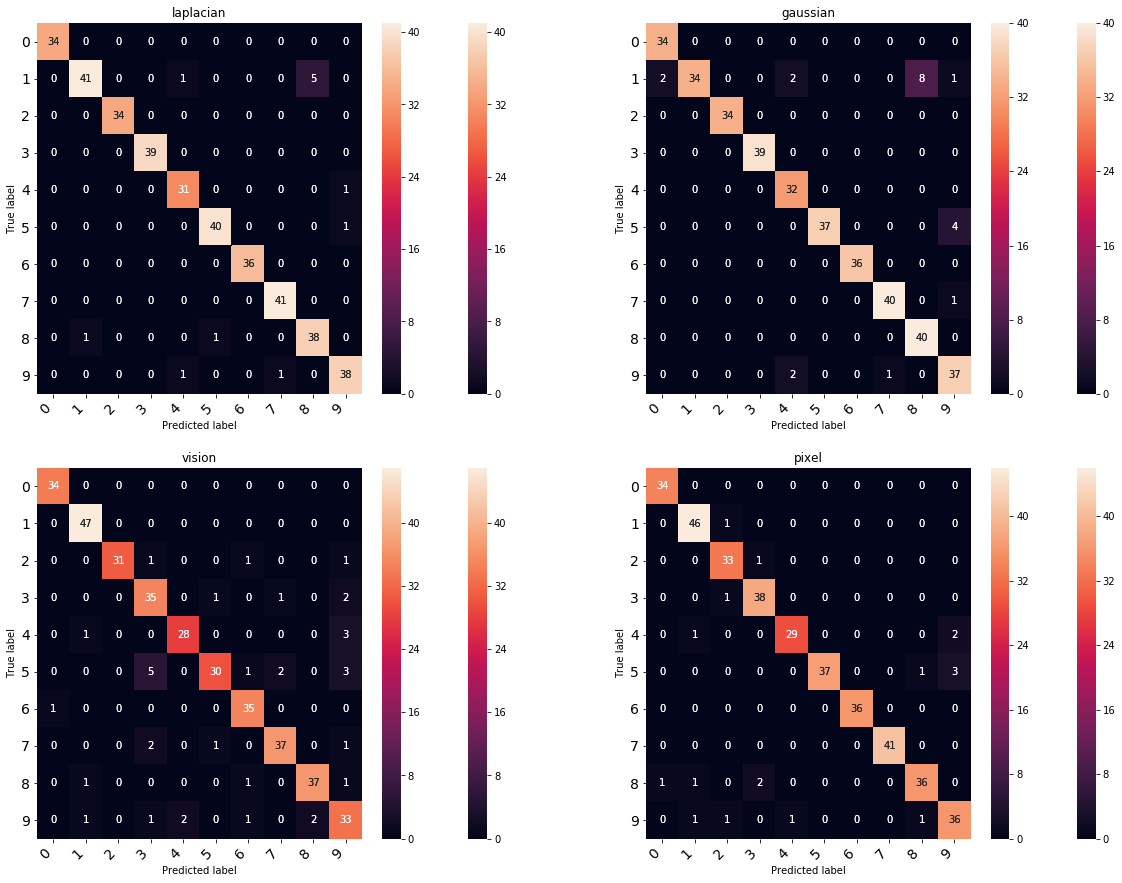

In [36]:
#zorg dat bovenstaande code cell gerunt is. 
from sklearn.metrics import classification_report

print("Laplacian dataset")
print(classification_report(y_pred=prediction_lap,y_true=y_test_laplacian))
print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][0])

print("Gaussian dataset")
print(classification_report(y_pred=prediction_gau,y_true=y_test_gaussian))
print_confusion_matrix(confusion_matrix(y_test_gaussian, prediction_gau,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[0][1])

print("Pixel dataset")
print(classification_report(y_pred=prediction_pix,y_true=y_test_pixel))
print_confusion_matrix(confusion_matrix(y_test_pixel, prediction_pix,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][1])

print("Vision dataset")
print(classification_report(y_pred=prediction_vis,y_true=y_test_vision))
print_confusion_matrix(confusion_matrix(y_test_vision, prediction_vis,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax[1][0])





Uit de verschillende classification reports is duidelijk op te maken dat het model met de laplacian dataset het beste werkt. Het vision model presteert het slechtst dit komt voornamelijk omdat niet alle mogelijke data die in een afbeelding zit, verwerkt wordt in de verschillende features. 

Het model met de laplacian dataset heeft alleen nog moeite met de nummer 8. De huidige hypothese is dat dit komt omdat de laplacian dataset gedownscaled wordt en dat daarom de gaten die de nummer 8 herkenbaar maken onduidelijker worden door het downscalen. Ook zit er een nummer 8 in de dataset zonder gaten waardoor deze dus erg veel op een 1 lijkt. Het vision model heeft juist een goede accuracy als het gaat om het nummer 8 omdat de gaten hier op een volledige image gedetecteerd worden en als feature meegegeven. Deze hypothese wordt bevestigd door de confusion matrices. Hierin valt duidelijk uit te lezen dat het getal 8 voorspelt wordt als het nummer 1. Andersom is dit minder vaak het geval dit komt waarschijnlijk omdat het model eerder naar het getal 1 nijgt waardoor deze dus vaker goed voorspelt wordt. 



### Hyper parameters comparison laplacian SVC 

In [37]:
from sklearn.svm import SVC
parameters_c = [0.001, 0.01, 0.1, 1, 10]
parameters_gamma = [0.001, 0.01, 0.1, 1]

for c in parameters_c:
    for gamma in parameters_gamma:
        svclassifier_laplacian = SVC(C= c, gamma=gamma,kernel='rbf')
        svclassifier_laplacian.fit(X_train_laplacian,y_train_laplacian)
        print("SVC Laplacian Classifier:\t","C:",c,"Gamma:",gamma,svclassifier_laplacian.score(X_test_laplacian,y_test_laplacian))

# prediction_lap = pipe_laplacian_svm.predict(X_test_laplacian)

# fig, ax = plt.subplots(nrows=1, ncols=1)
# fig.set_figheight(15)
# fig.set_figwidth(20)
# ax.set_title(dataset_name)

# print_confusion_matrix(confusion_matrix(y_test_laplacian, prediction_lap,labels=[0,1,2,3,4,5,6,7,8,9]),[0,1,2,3,4,5,6,7,8,9],ax)



SVC Laplacian Classifier:	 C: 0.001 Gamma: 0.001 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.001 Gamma: 0.01 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.001 Gamma: 0.1 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.001 Gamma: 1 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.01 Gamma: 0.001 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.01 Gamma: 0.01 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.01 Gamma: 0.1 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.01 Gamma: 1 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.1 Gamma: 0.001 0.4166666666666667
SVC Laplacian Classifier:	 C: 0.1 Gamma: 0.01 0.9401041666666666
SVC Laplacian Classifier:	 C: 0.1 Gamma: 0.1 0.10416666666666667
SVC Laplacian Classifier:	 C: 0.1 Gamma: 1 0.10416666666666667
SVC Laplacian Classifier:	 C: 1 Gamma: 0.001 0.9505208333333334
SVC Laplacian Classifier:	 C: 1 Gamma: 0.01 0.96875
SVC Laplacian Classifier:	 C: 1 Gamma: 0.1 0.9322916666666666
SVC Laplacian Classifier:	 C:

|      SVR     |C >| 0.001             | 0.01                | 0.1                 | 1                   | 10                  |
|--------------|-|--------------------|---------------------|---------------------|---------------------|---------------------|
|GAMMA v        | |                    |                     |                     |                     |                     |
| 0.001        | |0.10416666666666667 | 0.10416666666666667 | 0.4166666666666667  | 0.9505208333333334  | 0.9739583333333334  |
| 0.01         | |0.10416666666666667 | 0.10416666666666667 | 0.9401041666666666  | 0.96875             | 0.984375            |
| 0.1          | |0.10416666666666667 | 0.10416666666666667 | 0.10416666666666667 | 0.9322916666666666  | 0.9322916666666666  |
| 1.0          | |0.10416666666666667 | 0.10416666666666667 | 0.10416666666666667 | 0.10416666666666667 | 0.10416666666666667 |

# Hyperparameter comparison laplacian model
#### C parameter

In de bovenstaande tabel zijn de resultaten van de verschillende hyperparameters uitgewerkt van de Support Vector Machine classifier. Er is duidelijk af te lezen dat een te lage penalty(C parameter) zorgt voor een slechte classifier dit komt omdat een lage penalty ervoor zorgt dat het niet belangrijk is om outliers in de data goed te classificeren en het belangrijker is om de "gemiddelde" data altijd goed te classificeren. Een lage C value is bijvoorbeeld goed wanneer er wordt gekeken of een patient gezond is. In dit geval is een False Positive heel gevaarlijk aangezien de patient dan niet gezond is maar wel als gezond wordt geclassificeerd. Een False Negative zorgt in dit geval alleen voor extra testen waaruit uit komt dat de patient wel gezond is. Dit is in dit geval dus niet erg. Om samen te vatten de lage score van de classifier heeft als voordeel dat je heel zeker kan zijn dat er alleen false negatives zijn en geen false positives. In een model voor getal herkenning maakt het niet uit of er false positives of false negatives zijn en daarom wordt er een hoge C waarde genomen. Dit zorgt voor een over het algemeen hogere score van het model. 

#### Gamma parameter

De gamma parameter geeft aan wat de invloed van één training example is. Een kleine gamma betekent een grote invloed en een grote gamma betekent een kleine invloed. Deze invloed heeft te maken met het verdelen (classificeren) van de verschillende test vectors. Wanneer de gamma klein is wordt er ook gekeken naar de waardes die ver van de verdeel lijn afliggen om te bepalen waar de lijn moet komen. Als de gamma groot is wordt er alleen maar gekeken naar de waardes die dicht bij de grens liggen. In de bovenste tabel is duidelijk af te lezen dat een kleine waarde van gamma het beter doet. Een kleine waarde van gamma zorgt ervoor dat ook de waardes die ver van de grens afliggen invloed hebben op de grens dit zorgt er voor dat de invloed van elk punt kleiner wordt aangezien er naar meer punten gekeken wordt. Bij de laplacian dataset liggen de waardes die gescheiden moeten waarschijnlijk dichtbij elkaar en dus is het beter om een kleine gamma waarde te nemen om een soort gemiddelde grens te nemen in plaats van een hele precieze. Wel is in de tabel af te lezen dat deze grens niet te gemiddeld moet zijn anders worden er meer getallen fout geclassificeerd. 

# Exporting final model with the highest score

Het beste model wordt hier geexporteerd om te gebruiken in het final_notebook

In [38]:
import pickle
print(ensemble_laplacian.score(X_test_laplacian,y_test_laplacian))
pickle.dump(ensemble_laplacian,open("../classifiers/laplacian_ensemble_classifier.joblib", 'wb'))

C:\Users\fmijs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9869791666666666
